# Create and Train the Deep Learning Model

In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, cohen_kappa_score
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold
from keras.layers.recurrent import GRU
from keras.models import Sequential, load_model
from keras.regularizers import l2
from keras.layers import Dense, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint, Callback
from keras import backend as K
from IPython.display import clear_output

Using TensorFlow backend.
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Load the Data

In [2]:
X_train = np.load('arrays/X_train_bark.npy')
X_test = np.load('arrays/X_test_bark.npy')
y_train = np.load('arrays/y_train_bark.npy')
y_test = np.load('arrays/y_test_bark.npy')

### Define the Model

In [3]:
num_classes = 2
token_length = 100
num_features = 8

def regularization_constructor(alpha):
    if alpha:
        return l2(alpha)
    else:
        return None

def create_model(dropout=0.3, recurrent_dropout=0.1, recurrent_num_hidden=50, num_hidden=200,
                 gru_activation='tanh', recurrent_activation='tanh', activation='relu',
                 rec_l2=None, ker_l2=None, bias_l2=None, act_l2=None, 
                 dense_ker_l2=None, dense_bias_l2=0.01, dense_act_l2=0.01, 
                 verbose=False):
    rec_l2 = regularization_constructor(rec_l2)
    ker_l2 = regularization_constructor(ker_l2)
    bias_l2 = regularization_constructor(bias_l2)
    act_l2 = regularization_constructor(act_l2)
    dense_ker_l2 = regularization_constructor(dense_ker_l2)
    dense_bias_l2 = regularization_constructor(dense_bias_l2)
    dense_act_l2 = regularization_constructor(dense_act_l2)
    
    model = Sequential()
    model.add(BatchNormalization(input_shape=(token_length, num_features,)))
    model.add(GRU(units=recurrent_num_hidden, return_sequences=False, recurrent_dropout=recurrent_dropout,
                        dropout=dropout, activation=gru_activation, recurrent_activation=recurrent_activation,
                        recurrent_regularizer=rec_l2,
                        kernel_regularizer=ker_l2,
                        bias_regularizer=bias_l2,
                        activity_regularizer=act_l2,
                        input_shape=(token_length, num_features,)))
    model.add(Dense(num_hidden, activation=activation,
                   kernel_regularizer=dense_ker_l2,
                   bias_regularizer=dense_bias_l2,
                   activity_regularizer=dense_act_l2))
    model.add(Dense(1, activation='sigmoid'))
    if verbose:
        print(model.summary())
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

### Define Training Callback Functions

In [21]:
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
train_plot = PlotLearning()

filepath="results/weights.best.bark.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)
fit_callbacks = [checkpoint, train_plot]

cross_val_filepath="results/cross-val-weights-{acc:.1f}.hdf5"
cross_checkpoint = ModelCheckpoint(cross_val_filepath, monitor='loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)
cross_callbacks = [cross_checkpoint]

### Train Hyperparameters

Define the Combinations

In [20]:
node_params = {
    'num_hidden': [50, 100, 200],
    'recurrent_num_hidden': [50, 100, 200]
}

activation_params = {
    'gru_activation': ['relu', 'tanh'],
    'activation': ['relu', 'tanh'],
    'recurrent_activation': ['relu', 'tanh']
}

dropout_params = {
    'dropout': [0, 0.1, 0.3],
    'recurrent_dropout': [0, 0.1, 0.3]
}

reg_params = {
    'dense_ker_l2': [None, 0.01],
    'dense_bias_l2': [None, 0.01],
    'dense_act_l2': [None, 0.01]
}

recurrent_reg_params = {
    'rec_l2': [None, 0.01],
    'ker_l2': [None, 0.01],
    'bias_l2': [None, 0.01],
    'act_l2': [None, 0.01]
}

num_splits = 3
num_epochs = 150

Fit Activation

In [6]:
best_params = dict()

In [7]:
model = KerasClassifier(build_fn=create_model, **best_params)
kfold = StratifiedKFold(n_splits=num_splits)
grid = GridSearchCV(model, activation_params, cv=kfold, error_score=0, verbose=0)
grid.fit(X_train, y_train, epochs=num_epochs)
print(grid.best_params_)
best_params.update(grid.best_params_)

Epoch 1/150
1999/1999 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0045
Epoch 2/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 3/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 4/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 5/150
1999/1999 [==============================] - 5s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 6/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 7/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 8/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 9/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 10/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 11/150


1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 84/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 85/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 86/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 87/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 88/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 89/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 90/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 91/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 92/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 93/150


2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 14/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 15/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 16/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 17/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 18/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 19/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 20/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 21/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 22/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 23/150


2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 96/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 97/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 98/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00: 0s - loss: nan - acc: 0.0000e+
Epoch 99/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 100/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 101/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 102/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 103/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 104/150
2000/2000 [==============================] - 4s 2ms/step - loss

2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 26/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 27/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 28/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 29/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 30/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 31/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 32/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 33/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 34/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 35/150


Epoch 107/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 108/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 109/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 110/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 111/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 112/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 113/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 114/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 115/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 116/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0

1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 38/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 39/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 40/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 41/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 42/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 43/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 44/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 45/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 46/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 47/150


1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 119/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 120/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 121/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 122/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 123/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 124/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 125/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 126/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 127/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoc

2000/2000 [==============================] - 4s 2ms/step - loss: 0.5214 - acc: 0.7305
Epoch 49/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5200 - acc: 0.7350
Epoch 50/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5136 - acc: 0.7490
Epoch 51/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5076 - acc: 0.7520
Epoch 52/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5167 - acc: 0.7400
Epoch 53/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5147 - acc: 0.7385
Epoch 54/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5024 - acc: 0.7385
Epoch 55/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5098 - acc: 0.7470
Epoch 56/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5313 - acc: 0.7460
Epoch 57/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5176 - acc: 0.7395
Epoch 58/150
2000/2000 

2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 130/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 131/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 132/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 133/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 134/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 135/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 136/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 137/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 138/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoc

2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 60/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 61/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 62/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 63/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 64/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 65/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 66/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 67/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 68/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 69/150


2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 141/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 142/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 143/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 144/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 145/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 146/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 147/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00: 0s - loss: nan
Epoch 148/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 149/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc:

1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 71/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 72/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 73/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 74/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 75/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 76/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 77/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 78/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 79/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 80/150


1999/1999 [==============================] - 1s 373us/step
Epoch 1/150
2000/2000 [==============================] - 6s 3ms/step - loss: nan - acc: 0.0055
Epoch 2/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 3/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 4/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 5/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 6/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 7/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 8/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 9/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 10/150
2000/2000 [==============================

2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 83/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 84/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 85/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 86/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 87/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 88/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 89/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 90/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 91/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 92/150


2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 13/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 14/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 15/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 16/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 17/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 18/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 19/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 20/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 21/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 22/150


2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 95/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 96/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 97/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 98/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 99/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 100/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 101/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 102/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 103/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 104

1999/1999 [==============================] - 4s 2ms/step - loss: 0.5460 - acc: 0.7404
Epoch 25/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5499 - acc: 0.7324
Epoch 26/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5514 - acc: 0.7224
Epoch 27/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5474 - acc: 0.7384
Epoch 28/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5708 - acc: 0.7349
Epoch 29/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5550 - acc: 0.7394
Epoch 30/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5806 - acc: 0.7314
Epoch 31/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5620 - acc: 0.7289
Epoch 32/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5456 - acc: 0.7384
Epoch 33/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5609 - acc: 0.7389
Epoch 34/150
1999/1999 

1999/1999 [==============================] - 4s 2ms/step - loss: 0.5381 - acc: 0.7509
Epoch 107/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5304 - acc: 0.7484
Epoch 108/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5178 - acc: 0.7474
Epoch 109/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5445 - acc: 0.7659
Epoch 110/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5206 - acc: 0.7499
Epoch 111/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5517 - acc: 0.7499
Epoch 112/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5331 - acc: 0.7589
Epoch 113/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5071 - acc: 0.7514
Epoch 114/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5349 - acc: 0.7574
Epoch 115/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5207 - acc: 0.7529
Epoch 116/150


2000/2000 [==============================] - 4s 2ms/step - loss: 0.5643 - acc: 0.7130
Epoch 38/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5547 - acc: 0.7190
Epoch 39/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5546 - acc: 0.7200
Epoch 40/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5517 - acc: 0.7215
Epoch 41/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5486 - acc: 0.7180
Epoch 42/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5512 - acc: 0.7220
Epoch 43/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5499 - acc: 0.7275
Epoch 44/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5374 - acc: 0.7365
Epoch 45/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5429 - acc: 0.7265
Epoch 46/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5284 - acc: 0.7380
Epoch 47/150
2000/2000 

2000/2000 [==============================] - 4s 2ms/step - loss: 0.5546 - acc: 0.7250
Epoch 120/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5878 - acc: 0.7325
Epoch 121/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6037 - acc: 0.7175
Epoch 122/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5910 - acc: 0.7205
Epoch 123/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6748 - acc: 0.7260
Epoch 124/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5825 - acc: 0.7275
Epoch 125/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5630 - acc: 0.7340
Epoch 126/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5643 - acc: 0.7105
Epoch 127/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5651 - acc: 0.7265
Epoch 128/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5395 - acc: 0.7190
Epoch 129/150


2001/2001 [==============================] - 4s 2ms/step - loss: 0.6052 - acc: 0.6847
Epoch 51/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6222 - acc: 0.6837
Epoch 52/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6001 - acc: 0.6697
Epoch 53/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5969 - acc: 0.6812
Epoch 54/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6018 - acc: 0.6817
Epoch 55/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6059 - acc: 0.6872
Epoch 56/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6095 - acc: 0.6842
Epoch 57/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5995 - acc: 0.6887
Epoch 58/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6047 - acc: 0.6912
Epoch 59/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6110 - acc: 0.6762
Epoch 60/150
2001/2001 

2001/2001 [==============================] - 4s 2ms/step - loss: 0.5938 - acc: 0.6892
Epoch 133/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6082 - acc: 0.6852
Epoch 134/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6049 - acc: 0.6902
Epoch 135/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5946 - acc: 0.6967
Epoch 136/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6149 - acc: 0.6967
Epoch 137/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5951 - acc: 0.6952
Epoch 138/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6089 - acc: 0.6962
Epoch 139/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5946 - acc: 0.6917
Epoch 140/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6064 - acc: 0.6872
Epoch 141/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5963 - acc: 0.6907
Epoch 142/150


1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 64/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 65/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 66/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 67/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 68/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 69/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 70/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 71/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 72/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 73/150


1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 145/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 146/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 147/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 148/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 149/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 150/150
1999/1999 [==============================] - 1s 367us/step
Epoch 1/150
2000/2000 [==============================] - 7s 3ms/step - loss: nan - acc: 0.0055
Epoch 2/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 3/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 4/150
2000/2000 [===================

Epoch 75/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 76/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 77/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 78/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 79/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 80/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 81/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 82/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 83/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 84/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00


2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 6/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 7/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 8/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 9/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 10/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 11/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 12/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 13/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 14/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 15/150
2001

2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 88/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 89/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 90/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 91/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 92/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 93/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 94/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 95/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 96/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 97/150


1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 18/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 19/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 20/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 21/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 22/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 23/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 24/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 25/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 26/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 27/150


1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 100/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 101/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 102/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 103/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 104/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 105/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 106/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 107/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 108/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoc

2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 30/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 31/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 32/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 33/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 34/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 35/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 36/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 37/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 38/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 39/150


2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 111/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 112/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 113/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 114/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 115/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 116/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 117/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 118/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 119/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoc

2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 41/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 42/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 43/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 44/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 45/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 46/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 47/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 48/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 49/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 50/150


2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 122/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 123/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 124/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 125/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 126/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 127/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 128/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 129/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 130/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoc

1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 52/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 53/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 54/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 55/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 56/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 57/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 58/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 59/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 60/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 61/150


1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 133/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 134/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 135/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 136/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 137/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 138/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 139/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 140/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 141/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoc

2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 63/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 64/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 65/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 66/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 67/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 68/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 69/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 70/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 71/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 72/150


2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 144/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 145/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 146/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 147/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 148/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 149/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 150/150
2000/2000 [==============================] - 1s 367us/step
Epoch 1/150
2001/2001 [==============================] - 7s 4ms/step - loss: nan - acc: 0.0020
Epoch 2/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 3/150
2001/2001 [=================

Epoch 74/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 75/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 76/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 77/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 78/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 79/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 80/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 81/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 82/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 83/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00


1999/1999 [==============================] - 4s 2ms/step - loss: 0.6336 - acc: 0.6803
Epoch 5/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6219 - acc: 0.6903
Epoch 6/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6165 - acc: 0.6853
Epoch 7/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6146 - acc: 0.6853
Epoch 8/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6151 - acc: 0.6873
Epoch 9/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6008 - acc: 0.7009
Epoch 10/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6024 - acc: 0.6923
Epoch 11/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6063 - acc: 0.6968
Epoch 12/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5937 - acc: 0.6973
Epoch 13/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5951 - acc: 0.6898
Epoch 14/150
1999/1999 [====

1999/1999 [==============================] - 4s 2ms/step - loss: 0.4424 - acc: 0.8019
Epoch 87/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4514 - acc: 0.7884
Epoch 88/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4472 - acc: 0.7929
Epoch 89/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4559 - acc: 0.7904
Epoch 90/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4497 - acc: 0.7954
Epoch 91/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4503 - acc: 0.7954
Epoch 92/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4499 - acc: 0.7899
Epoch 93/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4448 - acc: 0.7904
Epoch 94/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4467 - acc: 0.7879
Epoch 95/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4538 - acc: 0.7844
Epoch 96/150
1999/1999 

Epoch 17/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6160 - acc: 0.6900
Epoch 18/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6041 - acc: 0.6910
Epoch 19/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6061 - acc: 0.6900
Epoch 20/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6100 - acc: 0.7000
Epoch 21/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6842 - acc: 0.6905
Epoch 22/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6329 - acc: 0.6915
Epoch 23/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6095 - acc: 0.6970
Epoch 24/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6439 - acc: 0.6960
Epoch 25/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6465 - acc: 0.6870
Epoch 26/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6061 - acc: 0.6970
Epoch 27/1

2000/2000 [==============================] - 4s 2ms/step - loss: 0.6619 - acc: 0.6815
Epoch 100/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6343 - acc: 0.6745
Epoch 101/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6309 - acc: 0.6735
Epoch 102/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6469 - acc: 0.6775
Epoch 103/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6199 - acc: 0.6895
Epoch 104/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6239 - acc: 0.6765
Epoch 105/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6428 - acc: 0.6815
Epoch 106/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6239 - acc: 0.6735
Epoch 107/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6161 - acc: 0.6820
Epoch 108/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6358 - acc: 0.6725
Epoch 109/150


Epoch 30/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5335 - acc: 0.7316
Epoch 31/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5274 - acc: 0.7361
Epoch 32/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5262 - acc: 0.7486
Epoch 33/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5244 - acc: 0.7471
Epoch 34/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5101 - acc: 0.7616
Epoch 35/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5252 - acc: 0.7441
Epoch 36/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5317 - acc: 0.7446
Epoch 37/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5598 - acc: 0.7451
Epoch 38/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5805 - acc: 0.7396
Epoch 39/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5386 - acc: 0.7576
Epoch 40/1

2001/2001 [==============================] - 4s 2ms/step - loss: 0.6768 - acc: 0.6752
Epoch 113/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6648 - acc: 0.6902
Epoch 114/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6279 - acc: 0.6977
Epoch 115/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6515 - acc: 0.6672
Epoch 116/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6480 - acc: 0.6757
Epoch 117/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6876 - acc: 0.6732
Epoch 118/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6581 - acc: 0.6747
Epoch 119/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6659 - acc: 0.6822
Epoch 120/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6481 - acc: 0.6697
Epoch 121/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6328 - acc: 0.6677
Epoch 122/150


3000/3000 [==============================] - 6s 2ms/step - loss: 0.4804 - acc: 0.7680
Epoch 44/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.4754 - acc: 0.7763
Epoch 45/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.4864 - acc: 0.7693
Epoch 46/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.4762 - acc: 0.7727
Epoch 47/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.4844 - acc: 0.7750
Epoch 48/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.4916 - acc: 0.7760
Epoch 49/150
3000/3000 [==============================] - 7s 2ms/step - loss: 0.4819 - acc: 0.7680
Epoch 50/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.4705 - acc: 0.7803
Epoch 51/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.4767 - acc: 0.7693
Epoch 52/150
3000/3000 [==============================] - 7s 2ms/step - loss: 0.4762 - acc: 0.7710
Epoch 53/150
3000/3000 

3000/3000 [==============================] - 6s 2ms/step - loss: 0.6545 - acc: 0.7160
Epoch 126/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.6014 - acc: 0.7320
Epoch 127/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.5664 - acc: 0.7367
Epoch 128/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.5656 - acc: 0.7320
Epoch 129/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.5762 - acc: 0.7430
Epoch 130/150
3000/3000 [==============================] - 7s 2ms/step - loss: 0.5676 - acc: 0.7393
Epoch 131/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.6087 - acc: 0.7240
Epoch 132/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.5744 - acc: 0.7197
Epoch 133/150
3000/3000 [==============================] - 7s 2ms/step - loss: 0.5696 - acc: 0.7180
Epoch 134/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.6056 - acc: 0.7130
Epoch 135/150


Fit Node Count

In [8]:
model = KerasClassifier(build_fn=create_model, **best_params)
kfold = StratifiedKFold(n_splits=num_splits)
grid = GridSearchCV(model, node_params, cv=kfold, error_score=0, verbose=0)
grid.fit(X_train, y_train, epochs=num_epochs)
print(grid.best_params_)
best_params.update(grid.best_params_)

Epoch 1/150
1999/1999 [==============================] - 8s 4ms/step - loss: 0.7445 - acc: 0.6388
Epoch 2/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6677 - acc: 0.6518
Epoch 3/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6524 - acc: 0.6528
Epoch 4/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6420 - acc: 0.6623
Epoch 5/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6326 - acc: 0.6658
Epoch 6/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6259 - acc: 0.6723
Epoch 7/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6256 - acc: 0.6713
Epoch 8/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6166 - acc: 0.6793
Epoch 9/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6130 - acc: 0.6828
Epoch 10/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6125 - acc: 0.6918
Epoch 11/150
1999/1

1999/1999 [==============================] - 4s 2ms/step - loss: 0.5381 - acc: 0.7349
Epoch 84/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5382 - acc: 0.7399
Epoch 85/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5438 - acc: 0.7364
Epoch 86/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5286 - acc: 0.7369
Epoch 87/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5367 - acc: 0.7444
Epoch 88/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5307 - acc: 0.7404
Epoch 89/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5371 - acc: 0.7334
Epoch 90/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5295 - acc: 0.7359
Epoch 91/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5280 - acc: 0.7479
Epoch 92/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5257 - acc: 0.7354
Epoch 93/150
1999/1999 

2000/2000 [==============================] - 4s 2ms/step - loss: 0.6180 - acc: 0.6705
Epoch 15/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6129 - acc: 0.6735
Epoch 16/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6085 - acc: 0.6775
Epoch 17/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6035 - acc: 0.6855
Epoch 18/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6011 - acc: 0.6850
Epoch 19/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6068 - acc: 0.6925
Epoch 20/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5940 - acc: 0.6925
Epoch 21/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5947 - acc: 0.6955
Epoch 22/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5917 - acc: 0.6915
Epoch 23/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6041 - acc: 0.7015
Epoch 24/150
2000/2000 

2000/2000 [==============================] - 4s 2ms/step - loss: 0.5656 - acc: 0.7230
Epoch 97/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5905 - acc: 0.7270
Epoch 98/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6242 - acc: 0.7245
Epoch 99/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5694 - acc: 0.7255
Epoch 100/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5587 - acc: 0.7180
Epoch 101/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5641 - acc: 0.7165
Epoch 102/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5753 - acc: 0.7235
Epoch 103/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6248 - acc: 0.7120
Epoch 104/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5706 - acc: 0.7250
Epoch 105/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5853 - acc: 0.7260
Epoch 106/150
200

2001/2001 [==============================] - 4s 2ms/step - loss: 0.5891 - acc: 0.6847
Epoch 28/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5853 - acc: 0.6902
Epoch 29/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5935 - acc: 0.7101
Epoch 30/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5759 - acc: 0.7126
Epoch 31/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5665 - acc: 0.7161
Epoch 32/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5706 - acc: 0.7116
Epoch 33/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5705 - acc: 0.7041
Epoch 34/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5650 - acc: 0.7231
Epoch 35/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5687 - acc: 0.7091
Epoch 36/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5522 - acc: 0.7336
Epoch 37/150
2001/2001 

2001/2001 [==============================] - 4s 2ms/step - loss: 0.4506 - acc: 0.7961
Epoch 110/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4673 - acc: 0.7971
Epoch 111/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4929 - acc: 0.7806
Epoch 112/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5275 - acc: 0.7801
Epoch 113/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7169 - acc: 0.7836
Epoch 114/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5374 - acc: 0.7761
Epoch 115/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5895 - acc: 0.7766
Epoch 116/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6171 - acc: 0.7796
Epoch 117/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5319 - acc: 0.7856
Epoch 118/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5748 - acc: 0.7766
Epoch 119/150


1999/1999 [==============================] - 4s 2ms/step - loss: 0.4867 - acc: 0.7954
Epoch 41/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5017 - acc: 0.7719
Epoch 42/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4810 - acc: 0.7849
Epoch 43/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4774 - acc: 0.7869
Epoch 44/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4768 - acc: 0.7779
Epoch 45/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4691 - acc: 0.7984A: 1s 
Epoch 46/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4804 - acc: 0.7714
Epoch 47/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4812 - acc: 0.7744
Epoch 48/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4711 - acc: 0.7804
Epoch 49/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4867 - acc: 0.7739
Epoch 50/150
1999

1999/1999 [==============================] - 4s 2ms/step - loss: 0.6601 - acc: 0.7609
Epoch 123/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6404 - acc: 0.7399
Epoch 124/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6235 - acc: 0.7359
Epoch 125/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6718 - acc: 0.7529
Epoch 126/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6737 - acc: 0.7489
Epoch 127/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6733 - acc: 0.7464
Epoch 128/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6276 - acc: 0.7429
Epoch 129/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6566 - acc: 0.7384
Epoch 130/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6115 - acc: 0.7434
Epoch 131/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6666 - acc: 0.7289
Epoch 132/150


2000/2000 [==============================] - 4s 2ms/step - loss: 0.6935 - acc: 0.6825
Epoch 54/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6813 - acc: 0.6755
Epoch 55/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7380 - acc: 0.6775
Epoch 56/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7373 - acc: 0.6700
Epoch 57/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7399 - acc: 0.6785
Epoch 58/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7259 - acc: 0.6665
Epoch 59/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6674 - acc: 0.6845
Epoch 60/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6497 - acc: 0.6680
Epoch 61/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6803 - acc: 0.6615
Epoch 62/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7253 - acc: 0.6740
Epoch 63/150
2000/2000 

2000/2000 [==============================] - 4s 2ms/step - loss: 0.7049 - acc: 0.6760
Epoch 136/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6537 - acc: 0.6725
Epoch 137/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6867 - acc: 0.6720
Epoch 138/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6473 - acc: 0.6710
Epoch 139/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6583 - acc: 0.6780
Epoch 140/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6563 - acc: 0.6760
Epoch 141/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6621 - acc: 0.6685
Epoch 142/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6640 - acc: 0.6825
Epoch 143/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6580 - acc: 0.6750
Epoch 144/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6423 - acc: 0.6755
Epoch 145/150


2001/2001 [==============================] - 4s 2ms/step - loss: 0.7166 - acc: 0.6517
Epoch 67/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6983 - acc: 0.6602
Epoch 68/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6954 - acc: 0.6622
Epoch 69/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6927 - acc: 0.6637
Epoch 70/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7175 - acc: 0.6557
Epoch 71/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7707 - acc: 0.6682
Epoch 72/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7675 - acc: 0.6667
Epoch 73/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6530 - acc: 0.6672
Epoch 74/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7349 - acc: 0.6497A: 2
Epoch 75/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7176 - acc: 0.6567
Epoch 76/150
2001/2

2001/2001 [==============================] - 4s 2ms/step - loss: 0.6459 - acc: 0.6602
Epoch 149/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6356 - acc: 0.6587
Epoch 150/150
2001/2001 [==============================] - 1s 484us/step
Epoch 1/150
1999/1999 [==============================] - 10s 5ms/step - loss: 0.6889 - acc: 0.6573
Epoch 2/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.6652 - acc: 0.6513
Epoch 3/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.6535 - acc: 0.6543
Epoch 4/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.6424 - acc: 0.6518
Epoch 5/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.6324 - acc: 0.6573
Epoch 6/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.7224 - acc: 0.6568
Epoch 7/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.6304 - acc: 0.6573
Epoch 8/150
1999/1999 [==============================]

1999/1999 [==============================] - 5s 3ms/step - loss: 0.7124 - acc: 0.6763
Epoch 80/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.6683 - acc: 0.6833
Epoch 81/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.7937 - acc: 0.6958
Epoch 82/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.7396 - acc: 0.6933
Epoch 83/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.7227 - acc: 0.6973
Epoch 84/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.6777 - acc: 0.7039
Epoch 85/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.6982 - acc: 0.6993
Epoch 86/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.6612 - acc: 0.7079
Epoch 87/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.7193 - acc: 0.7069
Epoch 88/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.7773 - acc: 0.7059
Epoch 89/150
1999/1999 

2000/2000 [==============================] - 5s 3ms/step - loss: 0.6388 - acc: 0.6505
Epoch 10/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.6339 - acc: 0.6575
Epoch 11/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.6303 - acc: 0.6555
Epoch 12/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.6393 - acc: 0.6495
Epoch 13/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.6540 - acc: 0.6505
Epoch 14/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.6365 - acc: 0.6535
Epoch 15/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.6394 - acc: 0.6535
Epoch 16/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.6351 - acc: 0.6585
Epoch 17/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.6513 - acc: 0.6580
Epoch 18/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.6475 - acc: 0.6580
Epoch 19/150
2000/2000 

2000/2000 [==============================] - 5s 3ms/step - loss: 0.6886 - acc: 0.6845
Epoch 92/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.6998 - acc: 0.6710
Epoch 93/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.6928 - acc: 0.6760
Epoch 94/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.7118 - acc: 0.6685
Epoch 95/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.8418 - acc: 0.6720
Epoch 96/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.7383 - acc: 0.6645
Epoch 97/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.7937 - acc: 0.6720
Epoch 98/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.7895 - acc: 0.6765
Epoch 99/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.7995 - acc: 0.6645
Epoch 100/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.8149 - acc: 0.6580
Epoch 101/150
2000/200

2001/2001 [==============================] - 5s 3ms/step - loss: 0.7067 - acc: 0.6502
Epoch 22/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.8188 - acc: 0.6467
Epoch 23/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.7660 - acc: 0.6522
Epoch 24/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.7765 - acc: 0.6552
Epoch 25/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.6882 - acc: 0.6472
Epoch 26/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.6759 - acc: 0.6477
Epoch 27/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.6547 - acc: 0.6517
Epoch 28/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.6713 - acc: 0.6592
Epoch 29/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.6798 - acc: 0.6587
Epoch 30/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.7081 - acc: 0.6582
Epoch 31/150
2001/2001 

2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 104/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 105/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 106/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 107/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 108/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 109/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 110/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 111/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 112/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoc

1999/1999 [==============================] - 4s 2ms/step - loss: 0.5461 - acc: 0.7374
Epoch 34/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5477 - acc: 0.7459
Epoch 35/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5876 - acc: 0.7354
Epoch 36/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5682 - acc: 0.7494
Epoch 37/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5528 - acc: 0.7539
Epoch 38/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5625 - acc: 0.7394
Epoch 39/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5547 - acc: 0.7389
Epoch 40/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5629 - acc: 0.7444
Epoch 41/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5484 - acc: 0.7474
Epoch 42/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5949 - acc: 0.7469
Epoch 43/150
1999/1999 

1999/1999 [==============================] - 4s 2ms/step - loss: 0.5623 - acc: 0.7324
Epoch 116/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6166 - acc: 0.7344
Epoch 117/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5630 - acc: 0.7269
Epoch 118/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5692 - acc: 0.7259
Epoch 119/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5864 - acc: 0.7434
Epoch 120/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5644 - acc: 0.7324
Epoch 121/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5544 - acc: 0.7404
Epoch 122/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5577 - acc: 0.7369
Epoch 123/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6196 - acc: 0.7309
Epoch 124/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5576 - acc: 0.7314
Epoch 125/150


2000/2000 [==============================] - 4s 2ms/step - loss: 0.6313 - acc: 0.7000
Epoch 47/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6227 - acc: 0.6960
Epoch 48/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6457 - acc: 0.6840
Epoch 49/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6046 - acc: 0.6980
Epoch 50/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6260 - acc: 0.6980
Epoch 51/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6053 - acc: 0.6995
Epoch 52/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6787 - acc: 0.6975
Epoch 53/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5858 - acc: 0.6985
Epoch 54/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6218 - acc: 0.6840
Epoch 55/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6221 - acc: 0.6880
Epoch 56/150
2000/2000 

2000/2000 [==============================] - 4s 2ms/step - loss: 0.6120 - acc: 0.6960
Epoch 129/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6147 - acc: 0.6920
Epoch 130/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6188 - acc: 0.6855
Epoch 131/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6231 - acc: 0.6725
Epoch 132/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6366 - acc: 0.6935
Epoch 133/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6602 - acc: 0.6900
Epoch 134/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6040 - acc: 0.6885
Epoch 135/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6234 - acc: 0.6950
Epoch 136/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6208 - acc: 0.6915
Epoch 137/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6491 - acc: 0.6990
Epoch 138/150


2001/2001 [==============================] - 5s 2ms/step - loss: 0.6031 - acc: 0.6922
Epoch 60/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6337 - acc: 0.6772
Epoch 61/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6087 - acc: 0.6812
Epoch 62/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6560 - acc: 0.6782
Epoch 63/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6685 - acc: 0.6827
Epoch 64/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6307 - acc: 0.6962
Epoch 65/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6261 - acc: 0.6827
Epoch 66/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6371 - acc: 0.6727
Epoch 67/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6134 - acc: 0.6887
Epoch 68/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5998 - acc: 0.6932
Epoch 69/150
2001/2001 

2001/2001 [==============================] - 4s 2ms/step - loss: 0.6458 - acc: 0.6797
Epoch 142/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6434 - acc: 0.6907
Epoch 143/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6168 - acc: 0.6737
Epoch 144/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6045 - acc: 0.6897
Epoch 145/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6113 - acc: 0.6852
Epoch 146/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6253 - acc: 0.6832
Epoch 147/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6382 - acc: 0.6852
Epoch 148/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6165 - acc: 0.6932
Epoch 149/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6021 - acc: 0.6937
Epoch 150/150
2001/2001 [==============================] - 1s 424us/step
Epoch 1/150
1999/1999 [==================

1999/1999 [==============================] - 4s 2ms/step - loss: 0.5835 - acc: 0.6978
Epoch 73/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5769 - acc: 0.7129
Epoch 74/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5922 - acc: 0.7069
Epoch 75/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5966 - acc: 0.7054
Epoch 76/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5850 - acc: 0.7194
Epoch 77/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5819 - acc: 0.7044
Epoch 78/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5994 - acc: 0.7084
Epoch 79/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5891 - acc: 0.7179
Epoch 80/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6058 - acc: 0.7089
Epoch 81/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6157 - acc: 0.7079
Epoch 82/150
1999/1999 

2000/2000 [==============================] - 4s 2ms/step - loss: 0.6638 - acc: 0.6475
Epoch 4/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6558 - acc: 0.6480
Epoch 5/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6511 - acc: 0.6485
Epoch 6/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6433 - acc: 0.6500
Epoch 7/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6412 - acc: 0.6500
Epoch 8/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6363 - acc: 0.6485
Epoch 9/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6370 - acc: 0.6535
Epoch 10/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6299 - acc: 0.6575
Epoch 11/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6303 - acc: 0.6560
Epoch 12/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6296 - acc: 0.6555
Epoch 13/150
2000/2000 [=====

2000/2000 [==============================] - 4s 2ms/step - loss: 0.8886 - acc: 0.6895
Epoch 86/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8634 - acc: 0.6945
Epoch 87/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8265 - acc: 0.6615
Epoch 88/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8129 - acc: 0.6775
Epoch 89/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.9482 - acc: 0.6860
Epoch 90/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8420 - acc: 0.6860
Epoch 91/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7570 - acc: 0.6720
Epoch 92/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7666 - acc: 0.6855
Epoch 93/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7100 - acc: 0.6670
Epoch 94/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7350 - acc: 0.6815
Epoch 95/150
2000/2000 

2001/2001 [==============================] - 4s 2ms/step - loss: 0.6190 - acc: 0.6492
Epoch 17/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6164 - acc: 0.6487
Epoch 18/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6123 - acc: 0.6492
Epoch 19/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6142 - acc: 0.6607
Epoch 20/150
2001/2001 [==============================] - 5s 2ms/step - loss: 0.6162 - acc: 0.6552
Epoch 21/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6089 - acc: 0.6587
Epoch 22/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6235 - acc: 0.6497
Epoch 23/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6150 - acc: 0.6567
Epoch 24/150
2001/2001 [==============================] - 5s 2ms/step - loss: 0.6157 - acc: 0.6607
Epoch 25/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6046 - acc: 0.6587
Epoch 26/150
2001/2001 

2001/2001 [==============================] - 4s 2ms/step - loss: 0.6820 - acc: 0.6912
Epoch 99/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7515 - acc: 0.6737
Epoch 100/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6996 - acc: 0.6797
Epoch 101/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6524 - acc: 0.6822
Epoch 102/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6246 - acc: 0.6682
Epoch 103/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7609 - acc: 0.6887
Epoch 104/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6463 - acc: 0.6817
Epoch 105/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6631 - acc: 0.6787
Epoch 106/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6760 - acc: 0.6672
Epoch 107/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7039 - acc: 0.6742
Epoch 108/150
2

1999/1999 [==============================] - 5s 3ms/step - loss: 0.9010 - acc: 0.6998
Epoch 30/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.8810 - acc: 0.7124
Epoch 31/150
1999/1999 [==============================] - 5s 3ms/step - loss: 1.8413 - acc: 0.7179
Epoch 32/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.8456 - acc: 0.7249
Epoch 33/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.6639 - acc: 0.7214
Epoch 34/150
1999/1999 [==============================] - 5s 3ms/step - loss: 2.6731 - acc: 0.7139
Epoch 35/150
1999/1999 [==============================] - 5s 3ms/step - loss: 1.1611 - acc: 0.7189
Epoch 36/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.9449 - acc: 0.7224
Epoch 37/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.7678 - acc: 0.7239
Epoch 38/150
1999/1999 [==============================] - 5s 3ms/step - loss: 2.1065 - acc: 0.7204
Epoch 39/150
1999/1999 

1999/1999 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 112/150
1999/1999 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 113/150
1999/1999 [==============================] - 5s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 114/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 115/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 116/150
1999/1999 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 117/150
1999/1999 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 118/150
1999/1999 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 119/150
1999/1999 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 120/150
1999/1999 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoc

Epoch 42/150
2000/2000 [==============================] - 5s 3ms/step - loss: 1.1859 - acc: 0.6485
Epoch 43/150
2000/2000 [==============================] - 5s 3ms/step - loss: 1.1462 - acc: 0.6490
Epoch 44/150
2000/2000 [==============================] - 5s 3ms/step - loss: 1.0973 - acc: 0.6480
Epoch 45/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.9341 - acc: 0.6475
Epoch 46/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.9496 - acc: 0.6465
Epoch 47/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.8122 - acc: 0.6475
Epoch 48/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.7705 - acc: 0.6480
Epoch 49/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.7545 - acc: 0.6460
Epoch 50/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.8170 - acc: 0.6470
Epoch 51/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.7153 - acc: 0.6455
Epoch 52/1

2000/2000 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 125/150
2000/2000 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 126/150
2000/2000 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 127/150
2000/2000 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 128/150
2000/2000 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 129/150
2000/2000 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 130/150
2000/2000 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 131/150
2000/2000 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 132/150
2000/2000 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 133/150
2000/2000 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoc

2001/2001 [==============================] - 5s 3ms/step - loss: 0.6776 - acc: 0.6887
Epoch 56/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.7175 - acc: 0.6932
Epoch 57/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.6985 - acc: 0.6942
Epoch 58/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.6993 - acc: 0.6937
Epoch 59/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.6615 - acc: 0.6912
Epoch 60/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.6526 - acc: 0.6902
Epoch 61/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.6913 - acc: 0.7041
Epoch 62/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.6529 - acc: 0.6952
Epoch 63/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.6448 - acc: 0.6857
Epoch 64/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.6491 - acc: 0.6917
Epoch 65/150
2001/2001 

2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 138/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 139/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 140/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 141/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 142/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 143/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 144/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 145/150
2001/2001 [==============================] - 5s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 146/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoc

1999/1999 [==============================] - 4s 2ms/step - loss: 0.5721 - acc: 0.7304
Epoch 69/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5680 - acc: 0.7234
Epoch 70/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5510 - acc: 0.7284
Epoch 71/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6284 - acc: 0.7294
Epoch 72/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6150 - acc: 0.7319
Epoch 73/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5962 - acc: 0.7289
Epoch 74/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5838 - acc: 0.7234
Epoch 75/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5811 - acc: 0.7204
Epoch 76/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5951 - acc: 0.7219
Epoch 77/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6069 - acc: 0.7234
Epoch 78/150
1999/1999 

1999/1999 [==============================] - 1s 401us/step
Epoch 1/150
2000/2000 [==============================] - 10s 5ms/step - loss: 0.7997 - acc: 0.6465
Epoch 2/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6749 - acc: 0.6480
Epoch 3/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6637 - acc: 0.6475
Epoch 4/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6529 - acc: 0.6475
Epoch 5/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6494 - acc: 0.6475
Epoch 6/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6452 - acc: 0.6475
Epoch 7/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6391 - acc: 0.6470
Epoch 8/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6348 - acc: 0.6480
Epoch 9/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6332 - acc: 0.6470
Epoch 10/150
2000/2000 [==============================] - 

2000/2000 [==============================] - 4s 2ms/step - loss: 0.6114 - acc: 0.6785
Epoch 82/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6078 - acc: 0.6685
Epoch 83/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6132 - acc: 0.6795
Epoch 84/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6181 - acc: 0.6705
Epoch 85/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6429 - acc: 0.6660
Epoch 86/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6496 - acc: 0.6830
Epoch 87/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6494 - acc: 0.6650
Epoch 88/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6224 - acc: 0.6730A: 1s - 
Epoch 89/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6361 - acc: 0.6750
Epoch 90/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7795 - acc: 0.6610
Epoch 91/150
20

2001/2001 [==============================] - 4s 2ms/step - loss: 0.6061 - acc: 0.6542
Epoch 13/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6112 - acc: 0.6522
Epoch 14/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6035 - acc: 0.6587
Epoch 15/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6062 - acc: 0.6572
Epoch 16/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5976 - acc: 0.6657
Epoch 17/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5969 - acc: 0.6667
Epoch 18/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5836 - acc: 0.6712
Epoch 19/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5986 - acc: 0.6697
Epoch 20/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5914 - acc: 0.6882
Epoch 21/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5956 - acc: 0.6907
Epoch 22/150
2001/2001 

2001/2001 [==============================] - 4s 2ms/step - loss: 0.5943 - acc: 0.7056
Epoch 95/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6120 - acc: 0.7126
Epoch 96/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5869 - acc: 0.7171
Epoch 97/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6152 - acc: 0.6932
Epoch 98/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5993 - acc: 0.7001
Epoch 99/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5779 - acc: 0.7026
Epoch 100/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5968 - acc: 0.7061
Epoch 101/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5971 - acc: 0.6872
Epoch 102/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5824 - acc: 0.7061
Epoch 103/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6602 - acc: 0.7036
Epoch 104/150
2001/

1999/1999 [==============================] - 5s 2ms/step - loss: 0.5275 - acc: 0.7599
Epoch 26/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5420 - acc: 0.7569
Epoch 27/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5394 - acc: 0.7509
Epoch 28/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5311 - acc: 0.7554
Epoch 29/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5420 - acc: 0.7564
Epoch 30/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5458 - acc: 0.7564
Epoch 31/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5214 - acc: 0.7509
Epoch 32/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5253 - acc: 0.7434
Epoch 33/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5257 - acc: 0.7559
Epoch 34/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5259 - acc: 0.7409
Epoch 35/150
1999/1999 

1999/1999 [==============================] - 4s 2ms/step - loss: 0.7756 - acc: 0.7384
Epoch 108/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5927 - acc: 0.7354
Epoch 109/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6324 - acc: 0.7294
Epoch 110/150
1999/1999 [==============================] - 4s 2ms/step - loss: 1.0073 - acc: 0.7349
Epoch 111/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6635 - acc: 0.7389
Epoch 112/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7624 - acc: 0.7374
Epoch 113/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6256 - acc: 0.7374
Epoch 114/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7760 - acc: 0.7479
Epoch 115/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6627 - acc: 0.7394
Epoch 116/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5954 - acc: 0.7434
Epoch 117/150


2000/2000 [==============================] - 4s 2ms/step - loss: 0.6523 - acc: 0.6665
Epoch 39/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6555 - acc: 0.6705
Epoch 40/150
2000/2000 [==============================] - 5s 2ms/step - loss: 0.6896 - acc: 0.6620
Epoch 41/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6529 - acc: 0.6670
Epoch 42/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7475 - acc: 0.6755
Epoch 43/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8030 - acc: 0.6635
Epoch 44/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7253 - acc: 0.6715
Epoch 45/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7366 - acc: 0.6725
Epoch 46/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7999 - acc: 0.6640
Epoch 47/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7767 - acc: 0.6675
Epoch 48/150
2000/2000 

2000/2000 [==============================] - 4s 2ms/step - loss: 0.6361 - acc: 0.6625
Epoch 121/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6691 - acc: 0.6590
Epoch 122/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6884 - acc: 0.6640
Epoch 123/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7078 - acc: 0.6635
Epoch 124/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6398 - acc: 0.6730
Epoch 125/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6676 - acc: 0.6670
Epoch 126/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6685 - acc: 0.6675
Epoch 127/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6372 - acc: 0.6665
Epoch 128/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6539 - acc: 0.6715
Epoch 129/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6575 - acc: 0.6665
Epoch 130/150


2001/2001 [==============================] - 4s 2ms/step - loss: 0.5942 - acc: 0.6957
Epoch 52/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5984 - acc: 0.6832
Epoch 53/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5933 - acc: 0.6982
Epoch 54/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6023 - acc: 0.6862
Epoch 55/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5895 - acc: 0.6917
Epoch 56/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5872 - acc: 0.6902
Epoch 57/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6013 - acc: 0.6972
Epoch 58/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5946 - acc: 0.6987
Epoch 59/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5992 - acc: 0.7051
Epoch 60/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5880 - acc: 0.6952
Epoch 61/150
2001/2001 

2001/2001 [==============================] - 4s 2ms/step - loss: 0.6069 - acc: 0.6962
Epoch 134/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6732 - acc: 0.7001
Epoch 135/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6609 - acc: 0.7026
Epoch 136/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6715 - acc: 0.7071
Epoch 137/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6573 - acc: 0.7021
Epoch 138/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6386 - acc: 0.7076
Epoch 139/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6143 - acc: 0.7076
Epoch 140/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6193 - acc: 0.7096
Epoch 141/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6479 - acc: 0.6947
Epoch 142/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6532 - acc: 0.7026
Epoch 143/150


1999/1999 [==============================] - 5s 3ms/step - loss: 0.6265 - acc: 0.7319
Epoch 65/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.7127 - acc: 0.7354
Epoch 66/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.7265 - acc: 0.7364
Epoch 67/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.6155 - acc: 0.7339
Epoch 68/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.5672 - acc: 0.7319
Epoch 69/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.7001 - acc: 0.7254
Epoch 70/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.7065 - acc: 0.7389
Epoch 71/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.8236 - acc: 0.7289
Epoch 72/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.6316 - acc: 0.7369
Epoch 73/150
1999/1999 [==============================] - 5s 3ms/step - loss: 0.6195 - acc: 0.7379
Epoch 74/150
1999/1999 

1999/1999 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 146/150
1999/1999 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 147/150
1999/1999 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 148/150
1999/1999 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 149/150
1999/1999 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 150/150
1999/1999 [==============================] - 2s 824us/step
Epoch 1/150
2000/2000 [==============================] - 12s 6ms/step - loss: 0.7103 - acc: 0.6510
Epoch 2/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.6718 - acc: 0.6495
Epoch 3/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.6826 - acc: 0.6480
Epoch 4/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.6786 - acc: 0.6480
Epoch 5/150
2000/2000 [====================

2000/2000 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 77/150
2000/2000 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 78/150
2000/2000 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 79/150
2000/2000 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 80/150
2000/2000 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 81/150
2000/2000 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 82/150
2000/2000 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 83/150
2000/2000 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 84/150
2000/2000 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 85/150
2000/2000 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 86/150


2001/2001 [==============================] - 5s 3ms/step - loss: 0.7717 - acc: 0.6477
Epoch 7/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.9308 - acc: 0.6472
Epoch 8/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.8202 - acc: 0.6482
Epoch 9/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.7434 - acc: 0.6477
Epoch 10/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.7182 - acc: 0.6477
Epoch 11/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.7188 - acc: 0.6477
Epoch 12/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.6698 - acc: 0.6477
Epoch 13/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.7807 - acc: 0.6477
Epoch 14/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.6696 - acc: 0.6477
Epoch 15/150
2001/2001 [==============================] - 5s 3ms/step - loss: 0.6557 - acc: 0.6477
Epoch 16/150
2001/2001 [==

2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 89/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 90/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 91/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 92/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 93/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 94/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 95/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 96/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 97/150
2001/2001 [==============================] - 5s 3ms/step - loss: nan - acc: 0.0000e+00
Epoch 98/150


3000/3000 [==============================] - 6s 2ms/step - loss: 0.5833 - acc: 0.6987
Epoch 19/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.6163 - acc: 0.7010
Epoch 20/150
3000/3000 [==============================] - 7s 2ms/step - loss: 0.6201 - acc: 0.6970
Epoch 21/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.6304 - acc: 0.7003
Epoch 22/150
3000/3000 [==============================] - 7s 2ms/step - loss: 0.5935 - acc: 0.7037
Epoch 23/150
3000/3000 [==============================] - 7s 2ms/step - loss: 0.6382 - acc: 0.7090
Epoch 24/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.6768 - acc: 0.7010
Epoch 25/150
3000/3000 [==============================] - 7s 2ms/step - loss: 0.6227 - acc: 0.7000
Epoch 26/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.6646 - acc: 0.7093
Epoch 27/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.6126 - acc: 0.7063
Epoch 28/150
3000/3000 

3000/3000 [==============================] - 6s 2ms/step - loss: 0.7137 - acc: 0.7070
Epoch 101/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.7145 - acc: 0.7077
Epoch 102/150
3000/3000 [==============================] - 7s 2ms/step - loss: 0.7128 - acc: 0.7133
Epoch 103/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.6932 - acc: 0.7100
Epoch 104/150
3000/3000 [==============================] - 7s 2ms/step - loss: 0.6831 - acc: 0.7027
Epoch 105/150
3000/3000 [==============================] - 7s 2ms/step - loss: 0.6379 - acc: 0.7043
Epoch 106/150
3000/3000 [==============================] - 7s 2ms/step - loss: 0.6161 - acc: 0.7087
Epoch 107/150
3000/3000 [==============================] - 7s 2ms/step - loss: 0.6098 - acc: 0.7123
Epoch 108/150
3000/3000 [==============================] - 6s 2ms/step - loss: 0.7041 - acc: 0.7060
Epoch 109/150
3000/3000 [==============================] - 7s 2ms/step - loss: 0.5901 - acc: 0.7013
Epoch 110/150


Fit Dropout

In [9]:
model = KerasClassifier(build_fn=create_model, **best_params)
kfold = StratifiedKFold(n_splits=num_splits)
grid = GridSearchCV(model, dropout_params, cv=kfold, error_score=0, verbose=0)
grid.fit(X_train, y_train, epochs=num_epochs)
print(grid.best_params_)
best_params.update(grid.best_params_)

Epoch 1/150
1999/1999 [==============================] - 10s 5ms/step - loss: 0.7138 - acc: 0.6398
Epoch 2/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6526 - acc: 0.6658
Epoch 3/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6366 - acc: 0.6698
Epoch 4/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6227 - acc: 0.6908
Epoch 5/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6106 - acc: 0.7234
Epoch 6/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5891 - acc: 0.7444
Epoch 7/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5728 - acc: 0.7544
Epoch 8/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5579 - acc: 0.7594
Epoch 9/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5462 - acc: 0.7679
Epoch 10/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5278 - acc: 0.7809
Epoch 11/150
1999/

1999/1999 [==============================] - 3s 2ms/step - loss: 0.3408 - acc: 0.8659
Epoch 84/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.3444 - acc: 0.8629
Epoch 85/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.3353 - acc: 0.8704
Epoch 86/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.3328 - acc: 0.8739
Epoch 87/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.3209 - acc: 0.8744
Epoch 88/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.3473 - acc: 0.8589
Epoch 89/150
1999/1999 [==============================] - 3s 1ms/step - loss: 0.3293 - acc: 0.8834
Epoch 90/150
1999/1999 [==============================] - 3s 1ms/step - loss: 0.3163 - acc: 0.8754
Epoch 91/150
1999/1999 [==============================] - 3s 1ms/step - loss: 0.3310 - acc: 0.8699
Epoch 92/150
1999/1999 [==============================] - 2s 1ms/step - loss: 0.3255 - acc: 0.8719
Epoch 93/150
1999/1999 

2000/2000 [==============================] - 3s 2ms/step - loss: 0.6247 - acc: 0.6625
Epoch 15/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6197 - acc: 0.6670
Epoch 16/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6171 - acc: 0.6665
Epoch 17/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6261 - acc: 0.6705
Epoch 18/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6202 - acc: 0.6715
Epoch 19/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6217 - acc: 0.6675
Epoch 20/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6191 - acc: 0.6715
Epoch 21/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6286 - acc: 0.6720
Epoch 22/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6081 - acc: 0.6710
Epoch 23/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6145 - acc: 0.6750
Epoch 24/150
2000/2000 

2000/2000 [==============================] - 3s 2ms/step - loss: 0.8974 - acc: 0.6810
Epoch 97/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.9587 - acc: 0.6895
Epoch 98/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6741 - acc: 0.6815
Epoch 99/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.7025 - acc: 0.6730
Epoch 100/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6414 - acc: 0.6725
Epoch 101/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6791 - acc: 0.6820
Epoch 102/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6256 - acc: 0.6885
Epoch 103/150
2000/2000 [==============================] - 3s 2ms/step - loss: 1.9011 - acc: 0.6820
Epoch 104/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.7067 - acc: 0.6835
Epoch 105/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6650 - acc: 0.6835
Epoch 106/150
200

2001/2001 [==============================] - 3s 2ms/step - loss: 0.4802 - acc: 0.7981
Epoch 28/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4714 - acc: 0.8036
Epoch 29/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4773 - acc: 0.7956
Epoch 30/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4724 - acc: 0.7936
Epoch 31/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4643 - acc: 0.8066
Epoch 32/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4648 - acc: 0.8006
Epoch 33/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4588 - acc: 0.7951
Epoch 34/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4604 - acc: 0.7991
Epoch 35/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4539 - acc: 0.7996
Epoch 36/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4478 - acc: 0.8066
Epoch 37/150
2001/2001 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.6595 - acc: 0.7176
Epoch 110/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6687 - acc: 0.7021
Epoch 111/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6824 - acc: 0.7166
Epoch 112/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6127 - acc: 0.7306
Epoch 113/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6624 - acc: 0.7296
Epoch 114/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5961 - acc: 0.7316
Epoch 115/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6072 - acc: 0.7356
Epoch 116/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6465 - acc: 0.7461
Epoch 117/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6157 - acc: 0.7296
Epoch 118/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6438 - acc: 0.7291
Epoch 119/150


1999/1999 [==============================] - 4s 2ms/step - loss: 0.4748 - acc: 0.7849
Epoch 41/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4822 - acc: 0.7884
Epoch 42/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6104 - acc: 0.7879
Epoch 43/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4881 - acc: 0.7779
Epoch 44/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4896 - acc: 0.7779
Epoch 45/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4803 - acc: 0.7764
Epoch 46/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5085 - acc: 0.7769
Epoch 47/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4948 - acc: 0.7864
Epoch 48/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5243 - acc: 0.7759
Epoch 49/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5450 - acc: 0.7754
Epoch 50/150
1999/1999 

1999/1999 [==============================] - 4s 2ms/step - loss: 0.5898 - acc: 0.7554
Epoch 123/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6085 - acc: 0.7469
Epoch 124/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5518 - acc: 0.7629
Epoch 125/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5474 - acc: 0.7629
Epoch 126/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5569 - acc: 0.7649
Epoch 127/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5504 - acc: 0.7574
Epoch 128/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5566 - acc: 0.7569
Epoch 129/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5756 - acc: 0.7634
Epoch 130/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5401 - acc: 0.7639
Epoch 131/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5259 - acc: 0.7564
Epoch 132/150


2000/2000 [==============================] - 4s 2ms/step - loss: 0.6300 - acc: 0.7205
Epoch 54/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7567 - acc: 0.7170
Epoch 55/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7188 - acc: 0.7160
Epoch 56/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7536 - acc: 0.7025
Epoch 57/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7430 - acc: 0.7040
Epoch 58/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7803 - acc: 0.7000
Epoch 59/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8402 - acc: 0.6985
Epoch 60/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7574 - acc: 0.7070
Epoch 61/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8078 - acc: 0.7070
Epoch 62/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8157 - acc: 0.6985
Epoch 63/150
2000/2000 

2000/2000 [==============================] - 4s 2ms/step - loss: 0.5809 - acc: 0.7030
Epoch 136/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6053 - acc: 0.7200
Epoch 137/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6137 - acc: 0.7095
Epoch 138/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6260 - acc: 0.7115
Epoch 139/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6074 - acc: 0.7055
Epoch 140/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6186 - acc: 0.7225
Epoch 141/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6374 - acc: 0.7130
Epoch 142/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6023 - acc: 0.7120
Epoch 143/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6074 - acc: 0.7165
Epoch 144/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5895 - acc: 0.7120
Epoch 145/150


2001/2001 [==============================] - 4s 2ms/step - loss: 0.8275 - acc: 0.7151
Epoch 67/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6473 - acc: 0.7026
Epoch 68/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7257 - acc: 0.7156
Epoch 69/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7149 - acc: 0.7096
Epoch 70/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6708 - acc: 0.7146
Epoch 71/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6237 - acc: 0.7161
Epoch 72/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5777 - acc: 0.7211
Epoch 73/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6036 - acc: 0.7061
Epoch 74/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5897 - acc: 0.7106
Epoch 75/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5677 - acc: 0.7191
Epoch 76/150
2001/2001 

2001/2001 [==============================] - 4s 2ms/step - loss: 0.5920 - acc: 0.7206
Epoch 149/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5841 - acc: 0.7166
Epoch 150/150
2001/2001 [==============================] - 1s 380us/step
Epoch 1/150
1999/1999 [==============================] - 11s 6ms/step - loss: 0.7053 - acc: 0.6643
Epoch 2/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6794 - acc: 0.6648
Epoch 3/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6924 - acc: 0.6668
Epoch 4/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6500 - acc: 0.6693
Epoch 5/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6294 - acc: 0.6773
Epoch 6/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6228 - acc: 0.6893
Epoch 7/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6467 - acc: 0.6863
Epoch 8/150
1999/1999 [==============================]

1999/1999 [==============================] - 4s 2ms/step - loss: 0.6216 - acc: 0.7199
Epoch 80/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6662 - acc: 0.7179
Epoch 81/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5901 - acc: 0.7149
Epoch 82/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6397 - acc: 0.7209
Epoch 83/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6134 - acc: 0.7199
Epoch 84/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6243 - acc: 0.7284
Epoch 85/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5900 - acc: 0.7164
Epoch 86/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6084 - acc: 0.7239
Epoch 87/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6383 - acc: 0.7149
Epoch 88/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6393 - acc: 0.7239
Epoch 89/150
1999/1999 

2000/2000 [==============================] - 4s 2ms/step - loss: 0.6291 - acc: 0.6855
Epoch 11/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6644 - acc: 0.6835
Epoch 12/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6665 - acc: 0.6875
Epoch 13/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6499 - acc: 0.6885
Epoch 14/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6563 - acc: 0.6875
Epoch 15/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6462 - acc: 0.6965
Epoch 16/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6442 - acc: 0.6990
Epoch 17/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6485 - acc: 0.6985
Epoch 18/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7971 - acc: 0.6950
Epoch 19/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6479 - acc: 0.7085
Epoch 20/150
2000/2000 

2000/2000 [==============================] - 4s 2ms/step - loss: 0.6238 - acc: 0.7095
Epoch 93/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6412 - acc: 0.7050
Epoch 94/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6158 - acc: 0.7040
Epoch 95/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6240 - acc: 0.6955
Epoch 96/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6194 - acc: 0.7105
Epoch 97/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6328 - acc: 0.7125
Epoch 98/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6050 - acc: 0.7080
Epoch 99/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6008 - acc: 0.7070
Epoch 100/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6131 - acc: 0.7075
Epoch 101/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6055 - acc: 0.7065
Epoch 102/150
2000/20

2001/2001 [==============================] - 4s 2ms/step - loss: 0.6144 - acc: 0.7231
Epoch 24/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6231 - acc: 0.7226
Epoch 25/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5872 - acc: 0.7191
Epoch 26/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6470 - acc: 0.7096
Epoch 27/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5866 - acc: 0.7171
Epoch 28/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5762 - acc: 0.7426
Epoch 29/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5995 - acc: 0.7196
Epoch 30/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5752 - acc: 0.7236
Epoch 31/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5745 - acc: 0.7221
Epoch 32/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5700 - acc: 0.7246
Epoch 33/150
2001/2001 

2001/2001 [==============================] - 4s 2ms/step - loss: 0.5614 - acc: 0.7296
Epoch 106/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6229 - acc: 0.7296
Epoch 107/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6027 - acc: 0.7346
Epoch 108/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5880 - acc: 0.7311
Epoch 109/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5760 - acc: 0.7411
Epoch 110/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6122 - acc: 0.7256
Epoch 111/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5757 - acc: 0.7316
Epoch 112/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6292 - acc: 0.7181
Epoch 113/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5852 - acc: 0.7266
Epoch 114/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5884 - acc: 0.7316
Epoch 115/150


1999/1999 [==============================] - 4s 2ms/step - loss: 0.5632 - acc: 0.7479
Epoch 37/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5340 - acc: 0.7514
Epoch 38/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5371 - acc: 0.7574
Epoch 39/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5834 - acc: 0.7424
Epoch 40/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5383 - acc: 0.7524
Epoch 41/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5163 - acc: 0.7534
Epoch 42/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5717 - acc: 0.7579
Epoch 43/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5540 - acc: 0.7464
Epoch 44/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5407 - acc: 0.7459
Epoch 45/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5995 - acc: 0.7539
Epoch 46/150
1999/1999 

1999/1999 [==============================] - 4s 2ms/step - loss: 0.5925 - acc: 0.7414
Epoch 119/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5617 - acc: 0.7494
Epoch 120/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5721 - acc: 0.7444
Epoch 121/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5808 - acc: 0.7364
Epoch 122/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5588 - acc: 0.7399
Epoch 123/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5746 - acc: 0.7339
Epoch 124/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5796 - acc: 0.7424
Epoch 125/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6025 - acc: 0.7424
Epoch 126/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6246 - acc: 0.7534
Epoch 127/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5732 - acc: 0.7519
Epoch 128/150


2000/2000 [==============================] - 4s 2ms/step - loss: 0.6190 - acc: 0.7045
Epoch 50/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6757 - acc: 0.6895
Epoch 51/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6477 - acc: 0.7075
Epoch 52/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5812 - acc: 0.7290
Epoch 53/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5729 - acc: 0.7295
Epoch 54/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5648 - acc: 0.7310
Epoch 55/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5881 - acc: 0.7175
Epoch 56/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6110 - acc: 0.7155
Epoch 57/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5777 - acc: 0.7225
Epoch 58/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6024 - acc: 0.7150
Epoch 59/150
2000/2000 

2000/2000 [==============================] - 4s 2ms/step - loss: 0.8633 - acc: 0.6475
Epoch 132/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8156 - acc: 0.6500
Epoch 133/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6518 - acc: 0.6540
Epoch 134/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5973 - acc: 0.6785
Epoch 135/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5917 - acc: 0.6895
Epoch 136/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6403 - acc: 0.6855
Epoch 137/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7679 - acc: 0.6535
Epoch 138/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7828 - acc: 0.6615
Epoch 139/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6577 - acc: 0.6660
Epoch 140/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7609 - acc: 0.6515
Epoch 141/150


2001/2001 [==============================] - 4s 2ms/step - loss: 0.6632 - acc: 0.7281
Epoch 63/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6010 - acc: 0.7491
Epoch 64/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5808 - acc: 0.7371
Epoch 65/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5711 - acc: 0.7386
Epoch 66/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5751 - acc: 0.7381
Epoch 67/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5657 - acc: 0.7421
Epoch 68/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5922 - acc: 0.7286
Epoch 69/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5678 - acc: 0.7371
Epoch 70/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5728 - acc: 0.7401
Epoch 71/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5655 - acc: 0.7431
Epoch 72/150
2001/2001 

2001/2001 [==============================] - 4s 2ms/step - loss: 0.6141 - acc: 0.7281
Epoch 145/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6670 - acc: 0.7346
Epoch 146/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5911 - acc: 0.7376
Epoch 147/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6026 - acc: 0.7296
Epoch 148/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5813 - acc: 0.7206
Epoch 149/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5560 - acc: 0.7356
Epoch 150/150
2001/2001 [==============================] - 1s 426us/step
Epoch 1/150
1999/1999 [==============================] - 12s 6ms/step - loss: 0.7177 - acc: 0.6558
Epoch 2/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6618 - acc: 0.6613
Epoch 3/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6463 - acc: 0.6728
Epoch 4/150
1999/1999 [=======================

1999/1999 [==============================] - 4s 2ms/step - loss: 0.6515 - acc: 0.7469
Epoch 76/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7525 - acc: 0.7439
Epoch 77/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.7161 - acc: 0.7449
Epoch 78/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6565 - acc: 0.7439
Epoch 79/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6169 - acc: 0.7469
Epoch 80/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6060 - acc: 0.7479
Epoch 81/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6228 - acc: 0.7529
Epoch 82/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6198 - acc: 0.7459
Epoch 83/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6126 - acc: 0.7419
Epoch 84/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5884 - acc: 0.7469
Epoch 85/150
1999/1999 

2000/2000 [==============================] - 5s 2ms/step - loss: 0.6491 - acc: 0.6505
Epoch 7/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6531 - acc: 0.6485
Epoch 8/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6375 - acc: 0.6515
Epoch 9/150
2000/2000 [==============================] - 5s 2ms/step - loss: 0.6333 - acc: 0.6510
Epoch 10/150
2000/2000 [==============================] - 5s 2ms/step - loss: 0.6281 - acc: 0.6525
Epoch 11/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6263 - acc: 0.6560
Epoch 12/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6237 - acc: 0.6550
Epoch 13/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6229 - acc: 0.6595
Epoch 14/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6165 - acc: 0.6660
Epoch 15/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6116 - acc: 0.6780
Epoch 16/150
2000/2000 [==

2000/2000 [==============================] - 4s 2ms/step - loss: 0.4681 - acc: 0.7725
Epoch 89/150
2000/2000 [==============================] - 5s 2ms/step - loss: 0.4753 - acc: 0.7725
Epoch 90/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4688 - acc: 0.7745
Epoch 91/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4783 - acc: 0.7785
Epoch 92/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4753 - acc: 0.7760
Epoch 93/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5688 - acc: 0.7675
Epoch 94/150
2000/2000 [==============================] - 5s 2ms/step - loss: 0.6240 - acc: 0.7555
Epoch 95/150
2000/2000 [==============================] - 5s 2ms/step - loss: 0.7748 - acc: 0.7520
Epoch 96/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8434 - acc: 0.7850
Epoch 97/150
2000/2000 [==============================] - 5s 2ms/step - loss: 0.5257 - acc: 0.7720
Epoch 98/150
2000/2000 

2001/2001 [==============================] - 4s 2ms/step - loss: 0.6399 - acc: 0.6577
Epoch 20/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6200 - acc: 0.6587
Epoch 21/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6280 - acc: 0.6617
Epoch 22/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7168 - acc: 0.6692
Epoch 23/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6495 - acc: 0.6627
Epoch 24/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6364 - acc: 0.6622
Epoch 25/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6520 - acc: 0.6662
Epoch 26/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6617 - acc: 0.6657
Epoch 27/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6355 - acc: 0.6612
Epoch 28/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6169 - acc: 0.6632
Epoch 29/150
2001/2001 

2001/2001 [==============================] - 4s 2ms/step - loss: 0.6986 - acc: 0.6797
Epoch 102/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6333 - acc: 0.6822
Epoch 103/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6768 - acc: 0.6807
Epoch 104/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6318 - acc: 0.6842
Epoch 105/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6104 - acc: 0.6797
Epoch 106/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6877 - acc: 0.6902
Epoch 107/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6637 - acc: 0.6772
Epoch 108/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7725 - acc: 0.6652
Epoch 109/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7237 - acc: 0.6732
Epoch 110/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6812 - acc: 0.6767
Epoch 111/150


1999/1999 [==============================] - 4s 2ms/step - loss: 0.5343 - acc: 0.7529
Epoch 33/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5264 - acc: 0.7524
Epoch 34/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5304 - acc: 0.7504
Epoch 35/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5241 - acc: 0.7454
Epoch 36/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5212 - acc: 0.7514
Epoch 37/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5215 - acc: 0.7664
Epoch 38/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5128 - acc: 0.7659
Epoch 39/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5141 - acc: 0.7609
Epoch 40/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5098 - acc: 0.7599
Epoch 41/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5100 - acc: 0.7659
Epoch 42/150
1999/1999 

1999/1999 [==============================] - 5s 2ms/step - loss: 0.7270 - acc: 0.7449
Epoch 115/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5452 - acc: 0.7549
Epoch 116/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.8768 - acc: 0.7609
Epoch 117/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5537 - acc: 0.7479
Epoch 118/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6508 - acc: 0.7544
Epoch 119/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6670 - acc: 0.7489
Epoch 120/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5858 - acc: 0.7459
Epoch 121/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5917 - acc: 0.7304
Epoch 122/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6011 - acc: 0.7274
Epoch 123/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5624 - acc: 0.7259
Epoch 124/150


2000/2000 [==============================] - 4s 2ms/step - loss: 0.6088 - acc: 0.6915
Epoch 46/150
2000/2000 [==============================] - 5s 2ms/step - loss: 0.6298 - acc: 0.6800
Epoch 47/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6351 - acc: 0.6795
Epoch 48/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6187 - acc: 0.6825
Epoch 49/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6040 - acc: 0.7065
Epoch 50/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6246 - acc: 0.6870
Epoch 51/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6423 - acc: 0.6910
Epoch 52/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6190 - acc: 0.6995
Epoch 53/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6295 - acc: 0.6805
Epoch 54/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6573 - acc: 0.6885
Epoch 55/150
2000/2000 

2000/2000 [==============================] - 4s 2ms/step - loss: 0.6467 - acc: 0.6915
Epoch 128/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7082 - acc: 0.6805
Epoch 129/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7056 - acc: 0.6850
Epoch 130/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6388 - acc: 0.6960
Epoch 131/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6560 - acc: 0.6940
Epoch 132/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6645 - acc: 0.6990
Epoch 133/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6474 - acc: 0.6890
Epoch 134/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6669 - acc: 0.6915
Epoch 135/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6900 - acc: 0.6915
Epoch 136/150
2000/2000 [==============================] - 5s 2ms/step - loss: 0.6317 - acc: 0.6895
Epoch 137/150


2001/2001 [==============================] - 5s 2ms/step - loss: 0.5988 - acc: 0.7146
Epoch 59/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6175 - acc: 0.6957
Epoch 60/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6650 - acc: 0.7041
Epoch 61/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6267 - acc: 0.7066
Epoch 62/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6889 - acc: 0.7041
Epoch 63/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6840 - acc: 0.6927
Epoch 64/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5980 - acc: 0.7086
Epoch 65/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.7285 - acc: 0.7116
Epoch 66/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6183 - acc: 0.7041
Epoch 67/150
2001/2001 [==============================] - 5s 2ms/step - loss: 0.6314 - acc: 0.7016
Epoch 68/150
2001/2001 

2001/2001 [==============================] - 4s 2ms/step - loss: 0.6104 - acc: 0.7101
Epoch 141/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5973 - acc: 0.7071
Epoch 142/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5981 - acc: 0.7056
Epoch 143/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6039 - acc: 0.7161
Epoch 144/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5794 - acc: 0.7141
Epoch 145/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6022 - acc: 0.6997
Epoch 146/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6122 - acc: 0.7066
Epoch 147/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6291 - acc: 0.7041
Epoch 148/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6076 - acc: 0.7096
Epoch 149/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6151 - acc: 0.7206
Epoch 150/150


1999/1999 [==============================] - 4s 2ms/step - loss: 0.4822 - acc: 0.7789
Epoch 72/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4737 - acc: 0.7739
Epoch 73/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4702 - acc: 0.7824
Epoch 74/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4655 - acc: 0.7919
Epoch 75/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4677 - acc: 0.7904
Epoch 76/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4693 - acc: 0.7914
Epoch 77/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4474 - acc: 0.7944
Epoch 78/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4590 - acc: 0.7904
Epoch 79/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4684 - acc: 0.7924
Epoch 80/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4660 - acc: 0.7689
Epoch 81/150
1999/1999 

2000/2000 [==============================] - 4s 2ms/step - loss: 0.6776 - acc: 0.6510
Epoch 3/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6640 - acc: 0.6480
Epoch 4/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6583 - acc: 0.6515
Epoch 5/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6536 - acc: 0.6480
Epoch 6/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6506 - acc: 0.6490
Epoch 7/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6458 - acc: 0.6510
Epoch 8/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6431 - acc: 0.6540
Epoch 9/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6384 - acc: 0.6500
Epoch 10/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6387 - acc: 0.6495
Epoch 11/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6339 - acc: 0.6590
Epoch 12/150
2000/2000 [======

Epoch 85/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5985 - acc: 0.6805
Epoch 86/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6007 - acc: 0.6905
Epoch 87/150
2000/2000 [==============================] - 3s 1ms/step - loss: 0.5868 - acc: 0.6960
Epoch 88/150
2000/2000 [==============================] - 3s 1ms/step - loss: 0.5994 - acc: 0.6885
Epoch 89/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5942 - acc: 0.6955
Epoch 90/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5957 - acc: 0.6895
Epoch 91/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5965 - acc: 0.6950
Epoch 92/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6024 - acc: 0.6840
Epoch 93/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5956 - acc: 0.7005
Epoch 94/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6071 - acc: 0.6915
Epoch 95/1

2001/2001 [==============================] - 4s 2ms/step - loss: 0.5858 - acc: 0.6892
Epoch 17/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5831 - acc: 0.6947
Epoch 18/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5752 - acc: 0.7156
Epoch 19/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5717 - acc: 0.7156
Epoch 20/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5627 - acc: 0.7121
Epoch 21/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5515 - acc: 0.7281
Epoch 22/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5409 - acc: 0.7376
Epoch 23/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5436 - acc: 0.7481
Epoch 24/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5381 - acc: 0.7356
Epoch 25/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5365 - acc: 0.7361
Epoch 26/150
2001/2001 

2001/2001 [==============================] - 4s 2ms/step - loss: 0.4421 - acc: 0.8041
Epoch 99/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4474 - acc: 0.8006
Epoch 100/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4525 - acc: 0.7891
Epoch 101/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4474 - acc: 0.7976
Epoch 102/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4433 - acc: 0.7986
Epoch 103/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5446 - acc: 0.7881
Epoch 104/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5065 - acc: 0.7816
Epoch 105/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5645 - acc: 0.7791
Epoch 106/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5300 - acc: 0.7851
Epoch 107/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5272 - acc: 0.7901
Epoch 108/150
2

1999/1999 [==============================] - 4s 2ms/step - loss: 0.5709 - acc: 0.7139
Epoch 30/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5775 - acc: 0.7184
Epoch 31/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5741 - acc: 0.7159
Epoch 32/150
1999/1999 [==============================] - 5s 2ms/step - loss: 0.5664 - acc: 0.7199
Epoch 33/150
1999/1999 [==============================] - 5s 2ms/step - loss: 0.5888 - acc: 0.7224
Epoch 34/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5854 - acc: 0.7184
Epoch 35/150
1999/1999 [==============================] - 5s 2ms/step - loss: 0.6012 - acc: 0.7144
Epoch 36/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5940 - acc: 0.7184
Epoch 37/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5736 - acc: 0.7184
Epoch 38/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6056 - acc: 0.7119
Epoch 39/150
1999/1999 

1999/1999 [==============================] - 4s 2ms/step - loss: 0.6228 - acc: 0.7129
Epoch 112/150
1999/1999 [==============================] - 5s 2ms/step - loss: 0.6290 - acc: 0.7074
Epoch 113/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5981 - acc: 0.7219
Epoch 114/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6426 - acc: 0.7174
Epoch 115/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6148 - acc: 0.7189
Epoch 116/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6912 - acc: 0.7069
Epoch 117/150
1999/1999 [==============================] - 5s 2ms/step - loss: 0.6408 - acc: 0.7184
Epoch 118/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6408 - acc: 0.7184
Epoch 119/150
1999/1999 [==============================] - 5s 2ms/step - loss: 0.6866 - acc: 0.7029
Epoch 120/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6088 - acc: 0.7284
Epoch 121/150


2000/2000 [==============================] - 4s 2ms/step - loss: 0.6398 - acc: 0.6625
Epoch 43/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6927 - acc: 0.6585
Epoch 44/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6422 - acc: 0.6650
Epoch 45/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6444 - acc: 0.6595
Epoch 46/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6540 - acc: 0.6585
Epoch 47/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6493 - acc: 0.6745
Epoch 48/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6512 - acc: 0.6700
Epoch 49/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6396 - acc: 0.6680
Epoch 50/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6399 - acc: 0.6565
Epoch 51/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6598 - acc: 0.6585
Epoch 52/150
2000/2000 

2000/2000 [==============================] - 4s 2ms/step - loss: 0.6806 - acc: 0.6730
Epoch 125/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6979 - acc: 0.6575
Epoch 126/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6743 - acc: 0.6725
Epoch 127/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6637 - acc: 0.6705
Epoch 128/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6680 - acc: 0.6685
Epoch 129/150
2000/2000 [==============================] - 5s 2ms/step - loss: 0.6472 - acc: 0.6650
Epoch 130/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6471 - acc: 0.6625
Epoch 131/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7028 - acc: 0.6685
Epoch 132/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6588 - acc: 0.6660
Epoch 133/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6725 - acc: 0.6575
Epoch 134/150


2001/2001 [==============================] - 4s 2ms/step - loss: 0.4970 - acc: 0.7771
Epoch 56/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5062 - acc: 0.7706
Epoch 57/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4874 - acc: 0.7741
Epoch 58/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5023 - acc: 0.7606
Epoch 59/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4869 - acc: 0.7771
Epoch 60/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4919 - acc: 0.7776
Epoch 61/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4908 - acc: 0.7851
Epoch 62/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4891 - acc: 0.7841
Epoch 63/150
2001/2001 [==============================] - 5s 2ms/step - loss: 0.4822 - acc: 0.7746
Epoch 64/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4824 - acc: 0.7686
Epoch 65/150
2001/2001 

2001/2001 [==============================] - 5s 2ms/step - loss: 0.4446 - acc: 0.8026
Epoch 138/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4419 - acc: 0.8066
Epoch 139/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4507 - acc: 0.7926
Epoch 140/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4413 - acc: 0.7951
Epoch 141/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4419 - acc: 0.8061
Epoch 142/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4430 - acc: 0.7926
Epoch 143/150
2001/2001 [==============================] - 5s 2ms/step - loss: 0.4398 - acc: 0.8021
Epoch 144/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4364 - acc: 0.8086
Epoch 145/150
2001/2001 [==============================] - 5s 2ms/step - loss: 0.4485 - acc: 0.7971
Epoch 146/150
2001/2001 [==============================] - 5s 2ms/step - loss: 0.4569 - acc: 0.7936
Epoch 147/150


1999/1999 [==============================] - 5s 2ms/step - loss: 0.5746 - acc: 0.7114
Epoch 69/150
1999/1999 [==============================] - 5s 2ms/step - loss: 0.5630 - acc: 0.7209
Epoch 70/150
1999/1999 [==============================] - 5s 2ms/step - loss: 0.5706 - acc: 0.7219
Epoch 71/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5592 - acc: 0.7154
Epoch 72/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5679 - acc: 0.7114
Epoch 73/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5649 - acc: 0.7124
Epoch 74/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5645 - acc: 0.7244
Epoch 75/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5702 - acc: 0.7144
Epoch 76/150
1999/1999 [==============================] - 5s 2ms/step - loss: 0.5621 - acc: 0.7169
Epoch 77/150
1999/1999 [==============================] - 5s 2ms/step - loss: 0.5632 - acc: 0.7229
Epoch 78/150
1999/1999 

1999/1999 [==============================] - 1s 440us/step
Epoch 1/150
2000/2000 [==============================] - 14s 7ms/step - loss: 0.8454 - acc: 0.6045
Epoch 2/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6859 - acc: 0.6490
Epoch 3/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6781 - acc: 0.6475
Epoch 4/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6839 - acc: 0.6475
Epoch 5/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6653 - acc: 0.6470
Epoch 6/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6663 - acc: 0.6470
Epoch 7/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6596 - acc: 0.6475
Epoch 8/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6527 - acc: 0.6475
Epoch 9/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6487 - acc: 0.6465
Epoch 10/150
2000/2000 [==============================] - 

2000/2000 [==============================] - 4s 2ms/step - loss: 0.7532 - acc: 0.6625
Epoch 82/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7646 - acc: 0.6670
Epoch 83/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6579 - acc: 0.6615
Epoch 84/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6755 - acc: 0.6610
Epoch 85/150
2000/2000 [==============================] - 5s 2ms/step - loss: 0.6851 - acc: 0.6600
Epoch 86/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6954 - acc: 0.6600
Epoch 87/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7309 - acc: 0.6615
Epoch 88/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6606 - acc: 0.6650
Epoch 89/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6472 - acc: 0.6600
Epoch 90/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6996 - acc: 0.6540
Epoch 91/150
2000/2000 

2001/2001 [==============================] - 4s 2ms/step - loss: 0.6755 - acc: 0.6502
Epoch 13/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6701 - acc: 0.6522
Epoch 14/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6707 - acc: 0.6497
Epoch 15/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6470 - acc: 0.6457
Epoch 16/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6362 - acc: 0.6502
Epoch 17/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6356 - acc: 0.6527
Epoch 18/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6568 - acc: 0.6497
Epoch 19/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6523 - acc: 0.6502
Epoch 20/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6418 - acc: 0.6507
Epoch 21/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6373 - acc: 0.6572
Epoch 22/150
2001/2001 

2001/2001 [==============================] - 4s 2ms/step - loss: 0.6151 - acc: 0.6697
Epoch 95/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6164 - acc: 0.6717
Epoch 96/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6177 - acc: 0.6657
Epoch 97/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6344 - acc: 0.6652
Epoch 98/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6248 - acc: 0.6697
Epoch 99/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6560 - acc: 0.6692
Epoch 100/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6323 - acc: 0.6687
Epoch 101/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6244 - acc: 0.6682
Epoch 102/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6271 - acc: 0.6707
Epoch 103/150
2001/2001 [==============================] - 5s 2ms/step - loss: 0.6212 - acc: 0.6662
Epoch 104/150
2001/

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Epoch 1/150
3000/3000 [==============================] - 15s 5ms/step - loss: 0.6998 - acc: 0.6440
Epoch 2/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6507 - acc: 0.6540
Epoch 3/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6351 - acc: 0.6527
Epoch 4/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6219 - acc: 0.6640
Epoch 5/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.7423 - acc: 0.6773
Epoch 6/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6344 - acc: 0.6797
Epoch 7/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6378 - acc: 0.6947
Epoch 8/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6303 - acc: 0.7013
Epoch 9/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6050 - acc: 0.7007
Epoch 10/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6099 - acc: 0.7057
Epoch 11/150
3000/

3000/3000 [==============================] - 5s 2ms/step - loss: 0.6164 - acc: 0.7260
Epoch 84/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6281 - acc: 0.7243
Epoch 85/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6015 - acc: 0.7287
Epoch 86/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.7157 - acc: 0.7323
Epoch 87/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6437 - acc: 0.7310
Epoch 88/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6032 - acc: 0.7257
Epoch 89/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.5652 - acc: 0.7267
Epoch 90/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.5972 - acc: 0.7323
Epoch 91/150
3000/3000 [==============================] - 4s 1ms/step - loss: 0.5663 - acc: 0.7223
Epoch 92/150
3000/3000 [==============================] - 4s 1ms/step - loss: 0.6603 - acc: 0.7330
Epoch 93/150
3000/3000 

Fit Regularization

In [10]:
model = KerasClassifier(build_fn=create_model, **best_params)
kfold = StratifiedKFold(n_splits=num_splits)
grid = GridSearchCV(model, reg_params, cv=kfold, error_score=0, verbose=0)
grid.fit(X_train, y_train, epochs=num_epochs)
print(grid.best_params_)
best_params.update(grid.best_params_)

Epoch 1/150
1999/1999 [==============================] - 13s 6ms/step - loss: 0.6025 - acc: 0.6948
Epoch 2/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5671 - acc: 0.7034
Epoch 3/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5376 - acc: 0.7274
Epoch 4/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5319 - acc: 0.7314
Epoch 5/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5235 - acc: 0.7299
Epoch 6/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5230 - acc: 0.7354
Epoch 7/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5144 - acc: 0.7409
Epoch 8/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5186 - acc: 0.7409
Epoch 9/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5124 - acc: 0.7379
Epoch 10/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4948 - acc: 0.7424
Epoch 11/150
1999/

1999/1999 [==============================] - 3s 2ms/step - loss: 0.4508 - acc: 0.7804
Epoch 84/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4452 - acc: 0.7904
Epoch 85/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4603 - acc: 0.7789
Epoch 86/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4613 - acc: 0.7804
Epoch 87/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4685 - acc: 0.7739
Epoch 88/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4667 - acc: 0.7629
Epoch 89/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4898 - acc: 0.7579
Epoch 90/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4895 - acc: 0.7719
Epoch 91/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4624 - acc: 0.7739A: 1s - loss:
Epoch 92/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4738 - acc: 0.7799
Epoch 93/1

2000/2000 [==============================] - 3s 2ms/step - loss: 0.5829 - acc: 0.7070
Epoch 15/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5628 - acc: 0.7150
Epoch 16/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5645 - acc: 0.7125
Epoch 17/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5584 - acc: 0.7135
Epoch 18/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5660 - acc: 0.7165
Epoch 19/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5645 - acc: 0.7175
Epoch 20/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5655 - acc: 0.7105
Epoch 21/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5483 - acc: 0.7185
Epoch 22/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5596 - acc: 0.7100
Epoch 23/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5541 - acc: 0.7200
Epoch 24/150
2000/2000 

2000/2000 [==============================] - 3s 2ms/step - loss: 0.5973 - acc: 0.6980
Epoch 97/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5634 - acc: 0.7195
Epoch 98/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5499 - acc: 0.7195
Epoch 99/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5517 - acc: 0.7220
Epoch 100/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5570 - acc: 0.7195
Epoch 101/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5511 - acc: 0.7315
Epoch 102/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5540 - acc: 0.7210
Epoch 103/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5586 - acc: 0.7250
Epoch 104/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5655 - acc: 0.7205
Epoch 105/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5634 - acc: 0.7220
Epoch 106/150
200

2001/2001 [==============================] - 3s 2ms/step - loss: 0.4881 - acc: 0.7611
Epoch 28/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4993 - acc: 0.7601
Epoch 29/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4875 - acc: 0.7601
Epoch 30/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4784 - acc: 0.7596
Epoch 31/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4752 - acc: 0.7731
Epoch 32/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4791 - acc: 0.7621
Epoch 33/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4814 - acc: 0.7741
Epoch 34/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4691 - acc: 0.7771
Epoch 35/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4665 - acc: 0.7756
Epoch 36/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4650 - acc: 0.7711
Epoch 37/150
2001/2001 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.4470 - acc: 0.7791
Epoch 110/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4544 - acc: 0.7771
Epoch 111/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4731 - acc: 0.7756
Epoch 112/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4970 - acc: 0.7591
Epoch 113/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4785 - acc: 0.7776
Epoch 114/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4968 - acc: 0.7606
Epoch 115/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4883 - acc: 0.7616
Epoch 116/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4782 - acc: 0.7621
Epoch 117/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4449 - acc: 0.7766
Epoch 118/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4567 - acc: 0.7826
Epoch 119/150


1999/1999 [==============================] - 3s 2ms/step - loss: 0.4821 - acc: 0.7564
Epoch 41/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4737 - acc: 0.7589
Epoch 42/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4871 - acc: 0.7584
Epoch 43/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5086 - acc: 0.7524
Epoch 44/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4976 - acc: 0.7554A: 0s - loss: 0.4920 - acc: 0.7
Epoch 45/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4843 - acc: 0.7584
Epoch 46/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4659 - acc: 0.7684
Epoch 47/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4665 - acc: 0.7584
Epoch 48/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4741 - acc: 0.7669
Epoch 49/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4717 - acc:

1999/1999 [==============================] - 3s 2ms/step - loss: 0.5047 - acc: 0.7649
Epoch 123/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5185 - acc: 0.7529
Epoch 124/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5180 - acc: 0.7519
Epoch 125/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5199 - acc: 0.7424
Epoch 126/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4976 - acc: 0.7544
Epoch 127/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5187 - acc: 0.7399
Epoch 128/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4990 - acc: 0.7619
Epoch 129/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4985 - acc: 0.7569
Epoch 130/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5134 - acc: 0.7474
Epoch 131/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5102 - acc: 0.7539
Epoch 132/150


2000/2000 [==============================] - 3s 2ms/step - loss: 0.6441 - acc: 0.6410
Epoch 54/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6279 - acc: 0.6670
Epoch 55/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6177 - acc: 0.6790
Epoch 56/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6266 - acc: 0.6570
Epoch 57/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6460 - acc: 0.6445
Epoch 58/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6529 - acc: 0.6460
Epoch 59/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6477 - acc: 0.6560
Epoch 60/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6446 - acc: 0.6365
Epoch 61/150
2000/2000 [==============================] - 3s 1ms/step - loss: 0.6355 - acc: 0.6580
Epoch 62/150
2000/2000 [==============================] - 3s 1ms/step - loss: 0.6342 - acc: 0.6485
Epoch 63/150
2000/2000 

2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 136/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 137/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 138/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 139/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 140/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 141/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 142/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 143/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 144/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoc

2001/2001 [==============================] - 3s 1ms/step - loss: 0.5375 - acc: 0.7331
Epoch 67/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5268 - acc: 0.7371
Epoch 68/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5223 - acc: 0.7221
Epoch 69/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5111 - acc: 0.7536
Epoch 70/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5125 - acc: 0.7376
Epoch 71/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5015 - acc: 0.7561
Epoch 72/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4970 - acc: 0.7521
Epoch 73/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4931 - acc: 0.7581
Epoch 74/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4908 - acc: 0.7541
Epoch 75/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4879 - acc: 0.7616
Epoch 76/150
2001/2001 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.5363 - acc: 0.7266
Epoch 149/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5505 - acc: 0.7246
Epoch 150/150
2001/2001 [==============================] - 1s 378us/step
Epoch 1/150
1999/1999 [==============================] - 13s 7ms/step - loss: 0.5977 - acc: 0.6943
Epoch 2/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5479 - acc: 0.7249
Epoch 3/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5139 - acc: 0.7379
Epoch 4/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4902 - acc: 0.7464
Epoch 5/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4834 - acc: 0.7524
Epoch 6/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4765 - acc: 0.7629
Epoch 7/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4728 - acc: 0.7534
Epoch 8/150
1999/1999 [==============================]

1999/1999 [==============================] - 3s 2ms/step - loss: 0.4658 - acc: 0.7734
Epoch 80/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4803 - acc: 0.7684
Epoch 81/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4978 - acc: 0.7634
Epoch 82/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4847 - acc: 0.7759
Epoch 83/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4905 - acc: 0.7664
Epoch 84/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4837 - acc: 0.7519
Epoch 85/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4636 - acc: 0.7749
Epoch 86/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4570 - acc: 0.7734
Epoch 87/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4546 - acc: 0.7854
Epoch 88/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4838 - acc: 0.7744
Epoch 89/150
1999/1999 

2000/2000 [==============================] - 3s 2ms/step - loss: 0.5752 - acc: 0.7090
Epoch 11/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5665 - acc: 0.7155
Epoch 12/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5564 - acc: 0.7165
Epoch 13/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5407 - acc: 0.7165
Epoch 14/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5301 - acc: 0.7290
Epoch 15/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5282 - acc: 0.7205
Epoch 16/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5235 - acc: 0.7280
Epoch 17/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5146 - acc: 0.7420
Epoch 18/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5099 - acc: 0.7355
Epoch 19/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5218 - acc: 0.7320
Epoch 20/150
2000/2000 

2000/2000 [==============================] - 3s 2ms/step - loss: 0.5197 - acc: 0.7495
Epoch 93/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5249 - acc: 0.7405
Epoch 94/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5315 - acc: 0.7345
Epoch 95/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5560 - acc: 0.7105
Epoch 96/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5684 - acc: 0.7050
Epoch 97/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5396 - acc: 0.7315
Epoch 98/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5593 - acc: 0.7140
Epoch 99/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5487 - acc: 0.7220
Epoch 100/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5424 - acc: 0.7330
Epoch 101/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5176 - acc: 0.7365
Epoch 102/150
2000/20

2001/2001 [==============================] - 3s 2ms/step - loss: 0.5297 - acc: 0.7396
Epoch 24/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5790 - acc: 0.7176
Epoch 25/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5915 - acc: 0.6912
Epoch 26/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5532 - acc: 0.7261
Epoch 27/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5016 - acc: 0.7526
Epoch 28/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5211 - acc: 0.7391
Epoch 29/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5213 - acc: 0.7486
Epoch 30/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5338 - acc: 0.7321
Epoch 31/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5675 - acc: 0.7016
Epoch 32/150
2001/2001 [==============================] - 3s 2ms/step - loss: nan - acc: 0.4683
Epoch 33/150
2001/2001 [==

2001/2001 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 106/150
2001/2001 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 107/150
2001/2001 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 108/150
2001/2001 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 109/150
2001/2001 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 110/150
2001/2001 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 111/150
2001/2001 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 112/150
2001/2001 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 113/150
2001/2001 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 114/150
2001/2001 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoc

1999/1999 [==============================] - 3s 2ms/step - loss: 0.5277 - acc: 0.7419
Epoch 36/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5125 - acc: 0.7449
Epoch 37/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5021 - acc: 0.7569
Epoch 38/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5083 - acc: 0.7504
Epoch 39/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5323 - acc: 0.7419
Epoch 40/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5198 - acc: 0.7374
Epoch 41/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5119 - acc: 0.7419
Epoch 42/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5117 - acc: 0.7474
Epoch 43/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5057 - acc: 0.7524
Epoch 44/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5065 - acc: 0.7504
Epoch 45/150
1999/1999 

1999/1999 [==============================] - 3s 2ms/step - loss: 0.5147 - acc: 0.7504
Epoch 118/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5104 - acc: 0.7499
Epoch 119/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5128 - acc: 0.7479
Epoch 120/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5134 - acc: 0.7564
Epoch 121/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5719 - acc: 0.7019
Epoch 122/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5172 - acc: 0.7369
Epoch 123/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5179 - acc: 0.7394
Epoch 124/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5024 - acc: 0.7484
Epoch 125/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5075 - acc: 0.7494
Epoch 126/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5106 - acc: 0.7404
Epoch 127/150


2000/2000 [==============================] - 3s 2ms/step - loss: 0.6020 - acc: 0.6935
Epoch 49/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6421 - acc: 0.6480
Epoch 50/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6284 - acc: 0.6640
Epoch 51/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6242 - acc: 0.6685
Epoch 52/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6293 - acc: 0.6665
Epoch 53/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6309 - acc: 0.6490
Epoch 54/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6338 - acc: 0.6550
Epoch 55/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6388 - acc: 0.6495
Epoch 56/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6200 - acc: 0.6710
Epoch 57/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6227 - acc: 0.6610
Epoch 58/150
2000/2000 

2000/2000 [==============================] - 3s 2ms/step - loss: 0.6223 - acc: 0.6790
Epoch 131/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6322 - acc: 0.6660
Epoch 132/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6336 - acc: 0.6505
Epoch 133/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6308 - acc: 0.6585
Epoch 134/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6299 - acc: 0.6675
Epoch 135/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6367 - acc: 0.6640
Epoch 136/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6338 - acc: 0.6590
Epoch 137/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6223 - acc: 0.6690
Epoch 138/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6111 - acc: 0.6865
Epoch 139/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6072 - acc: 0.6810
Epoch 140/150


2001/2001 [==============================] - 3s 1ms/step - loss: 0.5319 - acc: 0.7236
Epoch 62/150
2001/2001 [==============================] - 3s 1ms/step - loss: 0.5366 - acc: 0.7261
Epoch 63/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5355 - acc: 0.7281
Epoch 64/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5322 - acc: 0.7311
Epoch 65/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5303 - acc: 0.7411
Epoch 66/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5291 - acc: 0.7371
Epoch 67/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5279 - acc: 0.7376
Epoch 68/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5336 - acc: 0.7311
Epoch 69/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5162 - acc: 0.7406
Epoch 70/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5303 - acc: 0.7401
Epoch 71/150
2001/2001 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.5321 - acc: 0.7311
Epoch 144/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5312 - acc: 0.7441
Epoch 145/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5418 - acc: 0.7296
Epoch 146/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5361 - acc: 0.7341
Epoch 147/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5392 - acc: 0.7411
Epoch 148/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5407 - acc: 0.7286
Epoch 149/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5420 - acc: 0.7296
Epoch 150/150
2001/2001 [==============================] - 1s 389us/step
Epoch 1/150
1999/1999 [==============================] - 14s 7ms/step - loss: 0.7226 - acc: 0.6388
Epoch 2/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6615 - acc: 0.6638
Epoch 3/150
1999/1999 [=====================

1999/1999 [==============================] - 3s 2ms/step - loss: 0.5864 - acc: 0.7319
Epoch 75/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.8555 - acc: 0.7469
Epoch 76/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6936 - acc: 0.7384
Epoch 77/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.9107 - acc: 0.7379
Epoch 78/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.9243 - acc: 0.7384
Epoch 79/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6595 - acc: 0.7534
Epoch 80/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6165 - acc: 0.7534
Epoch 81/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.7465 - acc: 0.7489
Epoch 82/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.7639 - acc: 0.7429
Epoch 83/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6255 - acc: 0.7409
Epoch 84/150
1999/1999 

2000/2000 [==============================] - 3s 2ms/step - loss: 0.6405 - acc: 0.6560
Epoch 6/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6375 - acc: 0.6525
Epoch 7/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6372 - acc: 0.6555
Epoch 8/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6222 - acc: 0.6595
Epoch 9/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6136 - acc: 0.6760
Epoch 10/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6073 - acc: 0.6820
Epoch 11/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6948 - acc: 0.6790
Epoch 12/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6689 - acc: 0.6790
Epoch 13/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.8033 - acc: 0.6625
Epoch 14/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.7324 - acc: 0.6685
Epoch 15/150
2000/2000 [===

2000/2000 [==============================] - 3s 2ms/step - loss: 0.6430 - acc: 0.6975
Epoch 88/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6242 - acc: 0.7000
Epoch 89/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6314 - acc: 0.7075
Epoch 90/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6750 - acc: 0.7015
Epoch 91/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6111 - acc: 0.7050
Epoch 92/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6558 - acc: 0.6995
Epoch 93/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6193 - acc: 0.7020
Epoch 94/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6207 - acc: 0.7000
Epoch 95/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6597 - acc: 0.7100
Epoch 96/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6511 - acc: 0.7005
Epoch 97/150
2000/2000 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.5687 - acc: 0.7226
Epoch 19/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5588 - acc: 0.7281
Epoch 20/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5804 - acc: 0.7261
Epoch 21/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5649 - acc: 0.7281
Epoch 22/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6346 - acc: 0.7196
Epoch 23/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6112 - acc: 0.7056
Epoch 24/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5841 - acc: 0.7016
Epoch 25/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5737 - acc: 0.7141
Epoch 26/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5635 - acc: 0.7356
Epoch 27/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5737 - acc: 0.7201
Epoch 28/150
2001/2001 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.6489 - acc: 0.6477
Epoch 101/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6489 - acc: 0.6477
Epoch 102/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6489 - acc: 0.6477
Epoch 103/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6489 - acc: 0.6477
Epoch 104/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6489 - acc: 0.6477
Epoch 105/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6489 - acc: 0.6477
Epoch 106/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6489 - acc: 0.6477
Epoch 107/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6489 - acc: 0.6477
Epoch 108/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6489 - acc: 0.6477
Epoch 109/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6489 - acc: 0.6477
Epoch 110/150


1999/1999 [==============================] - 3s 2ms/step - loss: 0.5462 - acc: 0.7334
Epoch 32/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5439 - acc: 0.7389
Epoch 33/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5440 - acc: 0.7414
Epoch 34/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5438 - acc: 0.7439
Epoch 35/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5471 - acc: 0.7374
Epoch 36/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5402 - acc: 0.7434
Epoch 37/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5523 - acc: 0.7419
Epoch 38/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5467 - acc: 0.7404
Epoch 39/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5442 - acc: 0.7414
Epoch 40/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5442 - acc: 0.7424
Epoch 41/150
1999/1999 

1999/1999 [==============================] - 3s 2ms/step - loss: 0.5175 - acc: 0.7509
Epoch 114/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5162 - acc: 0.7494
Epoch 115/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5167 - acc: 0.7619
Epoch 116/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5409 - acc: 0.7434
Epoch 117/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5096 - acc: 0.7549
Epoch 118/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5074 - acc: 0.7584
Epoch 119/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5075 - acc: 0.7609
Epoch 120/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5007 - acc: 0.7544
Epoch 121/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4984 - acc: 0.7634
Epoch 122/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5138 - acc: 0.7559
Epoch 123/150


2000/2000 [==============================] - 3s 2ms/step - loss: 0.5308 - acc: 0.7405
Epoch 45/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5542 - acc: 0.7205
Epoch 46/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5629 - acc: 0.7220
Epoch 47/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5854 - acc: 0.7150
Epoch 48/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5457 - acc: 0.7315
Epoch 49/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5787 - acc: 0.7065
Epoch 50/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5676 - acc: 0.7175
Epoch 51/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5718 - acc: 0.7050
Epoch 52/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5782 - acc: 0.7210
Epoch 53/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5745 - acc: 0.7220
Epoch 54/150
2000/2000 

2000/2000 [==============================] - 3s 2ms/step - loss: 0.5912 - acc: 0.7085
Epoch 127/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6079 - acc: 0.7145
Epoch 128/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5836 - acc: 0.7200
Epoch 129/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5850 - acc: 0.7200
Epoch 130/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6023 - acc: 0.7215
Epoch 131/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6367 - acc: 0.6820
Epoch 132/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6061 - acc: 0.7100
Epoch 133/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6177 - acc: 0.7075
Epoch 134/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6043 - acc: 0.7145
Epoch 135/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6301 - acc: 0.6825
Epoch 136/150


2001/2001 [==============================] - 3s 1ms/step - loss: 0.5536 - acc: 0.7486
Epoch 58/150
2001/2001 [==============================] - 3s 1ms/step - loss: 0.5749 - acc: 0.7351
Epoch 59/150
2001/2001 [==============================] - 3s 1ms/step - loss: 0.5848 - acc: 0.7271
Epoch 60/150
2001/2001 [==============================] - 3s 1ms/step - loss: 0.5882 - acc: 0.7246
Epoch 61/150
2001/2001 [==============================] - 3s 1ms/step - loss: 0.5821 - acc: 0.7241
Epoch 62/150
2001/2001 [==============================] - 3s 1ms/step - loss: 0.6455 - acc: 0.6707
Epoch 63/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6277 - acc: 0.6657
Epoch 64/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5535 - acc: 0.7451
Epoch 65/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5773 - acc: 0.7071
Epoch 66/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5446 - acc: 0.7516
Epoch 67/150
2001/2001 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.5504 - acc: 0.7361
Epoch 140/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5657 - acc: 0.7366
Epoch 141/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5342 - acc: 0.7451
Epoch 142/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5605 - acc: 0.7251
Epoch 143/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5468 - acc: 0.7466
Epoch 144/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5494 - acc: 0.7356
Epoch 145/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5732 - acc: 0.7216
Epoch 146/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5481 - acc: 0.7426
Epoch 147/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5546 - acc: 0.7431
Epoch 148/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5463 - acc: 0.7431
Epoch 149/150


1999/1999 [==============================] - 3s 2ms/step - loss: 0.5489 - acc: 0.7299
Epoch 71/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5306 - acc: 0.7489
Epoch 72/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4921 - acc: 0.7839
Epoch 73/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5530 - acc: 0.7699
Epoch 74/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5579 - acc: 0.7674
Epoch 75/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4949 - acc: 0.7764
Epoch 76/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4927 - acc: 0.7839
Epoch 77/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5039 - acc: 0.7894
Epoch 78/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5255 - acc: 0.7689
Epoch 79/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5192 - acc: 0.7789
Epoch 80/150
1999/1999 

Epoch 1/150
2000/2000 [==============================] - 15s 7ms/step - loss: 0.7315 - acc: 0.6355
Epoch 2/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6713 - acc: 0.6570
Epoch 3/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6580 - acc: 0.6585
Epoch 4/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6477 - acc: 0.6665
Epoch 5/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6405 - acc: 0.6575
Epoch 6/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6314 - acc: 0.6640
Epoch 7/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6239 - acc: 0.6705
Epoch 8/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6206 - acc: 0.6730
Epoch 9/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6456 - acc: 0.6820
Epoch 10/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6285 - acc: 0.6860
Epoch 11/150
2000/

2000/2000 [==============================] - 3s 2ms/step - loss: 0.6303 - acc: 0.6890
Epoch 84/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6150 - acc: 0.6970
Epoch 85/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6537 - acc: 0.6890
Epoch 86/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6017 - acc: 0.7005
Epoch 87/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6070 - acc: 0.6855
Epoch 88/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6158 - acc: 0.6920
Epoch 89/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6194 - acc: 0.6870
Epoch 90/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5978 - acc: 0.6895
Epoch 91/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6018 - acc: 0.6980
Epoch 92/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6041 - acc: 0.6860
Epoch 93/150
2000/2000 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.5677 - acc: 0.7156
Epoch 14/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5699 - acc: 0.7261
Epoch 15/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5533 - acc: 0.7321
Epoch 16/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5454 - acc: 0.7436
Epoch 17/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5502 - acc: 0.7416
Epoch 18/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5313 - acc: 0.7541
Epoch 19/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5332 - acc: 0.7546
Epoch 20/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5228 - acc: 0.7621
Epoch 21/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5243 - acc: 0.7591
Epoch 22/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5160 - acc: 0.7721
Epoch 23/150
2001/2001 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.3697 - acc: 0.8416
Epoch 96/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.3693 - acc: 0.8446
Epoch 97/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.3712 - acc: 0.8456
Epoch 98/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.3675 - acc: 0.8431
Epoch 99/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.3743 - acc: 0.8396
Epoch 100/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.3665 - acc: 0.8381
Epoch 101/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.3579 - acc: 0.8521
Epoch 102/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.3644 - acc: 0.8446
Epoch 103/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.3487 - acc: 0.8551
Epoch 104/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.3498 - acc: 0.8591
Epoch 105/150
2001

1999/1999 [==============================] - 3s 2ms/step - loss: 0.6481 - acc: 0.6518
Epoch 27/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6052 - acc: 0.6853
Epoch 28/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5397 - acc: 0.7464
Epoch 29/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5480 - acc: 0.7234
Epoch 30/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5324 - acc: 0.7629
Epoch 31/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5145 - acc: 0.7674
Epoch 32/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5233 - acc: 0.7599
Epoch 33/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5043 - acc: 0.7709
Epoch 34/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5418 - acc: 0.7309
Epoch 35/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5391 - acc: 0.7164
Epoch 36/150
1999/1999 

1999/1999 [==============================] - 3s 2ms/step - loss: 0.5670 - acc: 0.7094
Epoch 109/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6202 - acc: 0.6763
Epoch 110/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6445 - acc: 0.6468
Epoch 111/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6353 - acc: 0.6558
Epoch 112/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6576 - acc: 0.6488
Epoch 113/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6633 - acc: 0.6478
Epoch 114/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6485 - acc: 0.6478
Epoch 115/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6481 - acc: 0.6463
Epoch 116/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6251 - acc: 0.6803
Epoch 117/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6285 - acc: 0.6693A: 0s - loss: 0

2000/2000 [==============================] - 3s 2ms/step - loss: 0.6168 - acc: 0.6790
Epoch 40/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6274 - acc: 0.6670
Epoch 41/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6233 - acc: 0.6735
Epoch 42/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6198 - acc: 0.6690
Epoch 43/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6164 - acc: 0.6775
Epoch 44/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6100 - acc: 0.6840
Epoch 45/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6169 - acc: 0.6685
Epoch 46/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6129 - acc: 0.6760
Epoch 47/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6121 - acc: 0.6825
Epoch 48/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6161 - acc: 0.6725
Epoch 49/150
2000/2000 

2000/2000 [==============================] - 3s 2ms/step - loss: 0.6084 - acc: 0.6775
Epoch 122/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6095 - acc: 0.6825
Epoch 123/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6138 - acc: 0.6785
Epoch 124/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6189 - acc: 0.6745
Epoch 125/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6202 - acc: 0.6705
Epoch 126/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6246 - acc: 0.6775
Epoch 127/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6165 - acc: 0.6715
Epoch 128/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6155 - acc: 0.6810
Epoch 129/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6162 - acc: 0.6780
Epoch 130/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6212 - acc: 0.6765
Epoch 131/150


2001/2001 [==============================] - 3s 2ms/step - loss: 0.5770 - acc: 0.7161
Epoch 53/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5774 - acc: 0.7046
Epoch 54/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5636 - acc: 0.7221
Epoch 55/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5651 - acc: 0.7181
Epoch 56/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5586 - acc: 0.7146
Epoch 57/150
2001/2001 [==============================] - 3s 1ms/step - loss: 0.5696 - acc: 0.7206
Epoch 58/150
2001/2001 [==============================] - 3s 1ms/step - loss: 0.5558 - acc: 0.7251
Epoch 59/150
2001/2001 [==============================] - 3s 1ms/step - loss: 0.5641 - acc: 0.7181
Epoch 60/150
2001/2001 [==============================] - 3s 1ms/step - loss: 0.5623 - acc: 0.7276
Epoch 61/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5571 - acc: 0.7226
Epoch 62/150
2001/2001 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.5768 - acc: 0.7281
Epoch 135/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5484 - acc: 0.7471
Epoch 136/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5441 - acc: 0.7516
Epoch 137/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5360 - acc: 0.7531
Epoch 138/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5521 - acc: 0.7421
Epoch 139/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5570 - acc: 0.7441
Epoch 140/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5465 - acc: 0.7531
Epoch 141/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5498 - acc: 0.7361
Epoch 142/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5456 - acc: 0.7451
Epoch 143/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5306 - acc: 0.7581
Epoch 144/150


/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Epoch 1/150
3000/3000 [==============================] - 17s 6ms/step - loss: 1.0231 - acc: 0.6447
Epoch 2/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.7482 - acc: 0.6477
Epoch 3/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6679 - acc: 0.6477
Epoch 4/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6498 - acc: 0.6477
Epoch 5/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6359 - acc: 0.6477
Epoch 6/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6255 - acc: 0.6477
Epoch 7/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6166 - acc: 0.6480
Epoch 8/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6097 - acc: 0.6473
Epoch 9/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6063 - acc: 0.6493
Epoch 10/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6057 - acc: 0.6577
Epoch 11/150
3000/

3000/3000 [==============================] - 5s 2ms/step - loss: 0.5984 - acc: 0.7000
Epoch 84/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.5882 - acc: 0.7023
Epoch 85/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6094 - acc: 0.7000
Epoch 86/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.5944 - acc: 0.7080
Epoch 87/150
3000/3000 [==============================] - 4s 1ms/step - loss: 0.6076 - acc: 0.7000
Epoch 88/150
3000/3000 [==============================] - 4s 1ms/step - loss: 0.6107 - acc: 0.6977
Epoch 89/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6009 - acc: 0.6987
Epoch 90/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6009 - acc: 0.7147
Epoch 91/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.5987 - acc: 0.7207
Epoch 92/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.5914 - acc: 0.7047
Epoch 93/150
3000/3000 

Fit Recurrent Regularization

In [11]:
model = KerasClassifier(build_fn=create_model, **best_params)
kfold = StratifiedKFold(n_splits=num_splits)
grid = GridSearchCV(model, recurrent_reg_params, cv=kfold, error_score=0, verbose=0)
grid.fit(X_train, y_train, epochs=num_epochs)
print(grid.best_params_)
best_params.update(grid.best_params_)

Epoch 1/150
1999/1999 [==============================] - 16s 8ms/step - loss: 1.0766 - acc: 0.6553
Epoch 2/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.8236 - acc: 0.6778
Epoch 3/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.7091 - acc: 0.6923
Epoch 4/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6575 - acc: 0.6968
Epoch 5/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6325 - acc: 0.6948
Epoch 6/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6225 - acc: 0.7069
Epoch 7/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6097 - acc: 0.7159
Epoch 8/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6018 - acc: 0.7219
Epoch 9/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5980 - acc: 0.7264
Epoch 10/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5832 - acc: 0.7309
Epoch 11/150
1999/

1999/1999 [==============================] - 3s 2ms/step - loss: 0.5126 - acc: 0.7714
Epoch 84/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4898 - acc: 0.7784
Epoch 85/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4790 - acc: 0.7869
Epoch 86/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4691 - acc: 0.7879
Epoch 87/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4766 - acc: 0.7834
Epoch 88/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4610 - acc: 0.7974
Epoch 89/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4506 - acc: 0.8079
Epoch 90/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4368 - acc: 0.8069
Epoch 91/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5296 - acc: 0.7904
Epoch 92/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5063 - acc: 0.7804
Epoch 93/150
1999/1999 

2000/2000 [==============================] - 3s 2ms/step - loss: 0.6075 - acc: 0.7040
Epoch 15/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6057 - acc: 0.7000
Epoch 16/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6005 - acc: 0.7080
Epoch 17/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6007 - acc: 0.7060
Epoch 18/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5945 - acc: 0.7075
Epoch 19/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5945 - acc: 0.7075
Epoch 20/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5924 - acc: 0.7080
Epoch 21/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5958 - acc: 0.7060
Epoch 22/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6079 - acc: 0.7050
Epoch 23/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5898 - acc: 0.7120
Epoch 24/150
2000/2000 

2000/2000 [==============================] - 3s 2ms/step - loss: 0.5820 - acc: 0.7000
Epoch 97/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5941 - acc: 0.7060
Epoch 98/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5862 - acc: 0.7045
Epoch 99/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5997 - acc: 0.7070
Epoch 100/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5897 - acc: 0.7035
Epoch 101/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5823 - acc: 0.7060
Epoch 102/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5880 - acc: 0.7080
Epoch 103/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5763 - acc: 0.7085
Epoch 104/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5880 - acc: 0.7130
Epoch 105/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5897 - acc: 0.7070
Epoch 106/150
200

2001/2001 [==============================] - 3s 2ms/step - loss: 0.5804 - acc: 0.6937
Epoch 28/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5731 - acc: 0.7036
Epoch 29/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5732 - acc: 0.6977
Epoch 30/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5719 - acc: 0.7046
Epoch 31/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5606 - acc: 0.7131
Epoch 32/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5522 - acc: 0.7301
Epoch 33/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5385 - acc: 0.7471
Epoch 34/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5312 - acc: 0.7401
Epoch 35/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5443 - acc: 0.7546
Epoch 36/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5723 - acc: 0.7301
Epoch 37/150
2001/2001 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.5777 - acc: 0.7016
Epoch 110/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5648 - acc: 0.7146
Epoch 111/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5505 - acc: 0.7251
Epoch 112/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5748 - acc: 0.7301
Epoch 113/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5498 - acc: 0.7341
Epoch 114/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5546 - acc: 0.7256
Epoch 115/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5527 - acc: 0.7366
Epoch 116/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5619 - acc: 0.7281
Epoch 117/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5587 - acc: 0.7301
Epoch 118/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5609 - acc: 0.7261
Epoch 119/150


1999/1999 [==============================] - 3s 2ms/step - loss: 0.4606 - acc: 0.8039
Epoch 41/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4591 - acc: 0.8024
Epoch 42/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4590 - acc: 0.8004
Epoch 43/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4521 - acc: 0.8079
Epoch 44/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4598 - acc: 0.7979
Epoch 45/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4584 - acc: 0.7954
Epoch 46/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4471 - acc: 0.8044
Epoch 47/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4500 - acc: 0.8079
Epoch 48/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4532 - acc: 0.8044
Epoch 49/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4427 - acc: 0.8069
Epoch 50/150
1999/1999 

1999/1999 [==============================] - 3s 2ms/step - loss: 0.4045 - acc: 0.8219
Epoch 123/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4140 - acc: 0.8239
Epoch 124/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4197 - acc: 0.8214
Epoch 125/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4079 - acc: 0.8234
Epoch 126/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4126 - acc: 0.8304
Epoch 127/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4117 - acc: 0.8109
Epoch 128/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4086 - acc: 0.8279
Epoch 129/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4252 - acc: 0.8144
Epoch 130/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4113 - acc: 0.8199
Epoch 131/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4035 - acc: 0.8284
Epoch 132/150


2000/2000 [==============================] - 3s 2ms/step - loss: 0.4943 - acc: 0.7635
Epoch 54/150
2000/2000 [==============================] - 3s 1ms/step - loss: 0.4906 - acc: 0.7660
Epoch 55/150
2000/2000 [==============================] - 3s 1ms/step - loss: 0.4926 - acc: 0.7690
Epoch 56/150
2000/2000 [==============================] - 3s 1ms/step - loss: 0.4947 - acc: 0.7625
Epoch 57/150
2000/2000 [==============================] - 3s 1ms/step - loss: 0.4919 - acc: 0.7675
Epoch 58/150
2000/2000 [==============================] - 3s 1ms/step - loss: 0.4865 - acc: 0.7650
Epoch 59/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4863 - acc: 0.7640
Epoch 60/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4879 - acc: 0.7665
Epoch 61/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4934 - acc: 0.7675
Epoch 62/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4880 - acc: 0.7645
Epoch 63/150
2000/2000 

2000/2000 [==============================] - 3s 2ms/step - loss: 0.4520 - acc: 0.7915
Epoch 136/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4536 - acc: 0.7910
Epoch 137/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4595 - acc: 0.7880
Epoch 138/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4446 - acc: 0.7915
Epoch 139/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4451 - acc: 0.7975
Epoch 140/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4525 - acc: 0.7975
Epoch 141/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4479 - acc: 0.8075
Epoch 142/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4428 - acc: 0.8025
Epoch 143/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4429 - acc: 0.8020
Epoch 144/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4491 - acc: 0.7930
Epoch 145/150


2001/2001 [==============================] - 3s 2ms/step - loss: 0.4658 - acc: 0.7846
Epoch 67/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4653 - acc: 0.7906
Epoch 68/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4635 - acc: 0.7881
Epoch 69/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4607 - acc: 0.7881
Epoch 70/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4592 - acc: 0.7921
Epoch 71/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4614 - acc: 0.7851
Epoch 72/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4688 - acc: 0.7871
Epoch 73/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4628 - acc: 0.7911
Epoch 74/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4523 - acc: 0.7946
Epoch 75/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4581 - acc: 0.7911
Epoch 76/150
2001/2001 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.4365 - acc: 0.8021
Epoch 149/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4285 - acc: 0.8046
Epoch 150/150
2001/2001 [==============================] - 1s 388us/step
Epoch 1/150
1999/1999 [==============================] - 16s 8ms/step - loss: 1.1795 - acc: 0.6583
Epoch 2/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.8724 - acc: 0.6788
Epoch 3/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.7289 - acc: 0.6943
Epoch 4/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6679 - acc: 0.7089
Epoch 5/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6392 - acc: 0.7219
Epoch 6/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6105 - acc: 0.7454
Epoch 7/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5936 - acc: 0.7554
Epoch 8/150
1999/1999 [==============================]

1999/1999 [==============================] - 3s 2ms/step - loss: 0.6143 - acc: 0.6748
Epoch 80/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6353 - acc: 0.6493
Epoch 81/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6754 - acc: 0.6368
Epoch 82/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6606 - acc: 0.6478
Epoch 83/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6499 - acc: 0.6683
Epoch 84/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6593 - acc: 0.6498
Epoch 85/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6494 - acc: 0.6683
Epoch 86/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6408 - acc: 0.6663
Epoch 87/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6120 - acc: 0.6688
Epoch 88/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5824 - acc: 0.6893
Epoch 89/150
1999/1999 

2000/2000 [==============================] - 3s 2ms/step - loss: 0.6303 - acc: 0.6475
Epoch 11/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6094 - acc: 0.6475
Epoch 12/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6221 - acc: 0.6475
Epoch 13/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6106 - acc: 0.6475
Epoch 14/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6176 - acc: 0.6475
Epoch 15/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5948 - acc: 0.6475
Epoch 16/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5905 - acc: 0.6475
Epoch 17/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5814 - acc: 0.6475
Epoch 18/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6110 - acc: 0.6475
Epoch 19/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6018 - acc: 0.6495
Epoch 20/150
2000/2000 

2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 93/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 94/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 95/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 96/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 97/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 98/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 99/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 100/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 101/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 102/1

2001/2001 [==============================] - 3s 2ms/step - loss: 0.6740 - acc: 0.6477
Epoch 23/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6734 - acc: 0.6447
Epoch 24/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6705 - acc: 0.6477
Epoch 25/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6655 - acc: 0.6477
Epoch 26/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6604 - acc: 0.6477
Epoch 27/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6601 - acc: 0.6477
Epoch 28/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6586 - acc: 0.6477
Epoch 29/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6577 - acc: 0.6477
Epoch 30/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6385 - acc: 0.6717
Epoch 31/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6253 - acc: 0.7101
Epoch 32/150
2001/2001 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.5334 - acc: 0.7681
Epoch 105/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5540 - acc: 0.7441
Epoch 106/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5730 - acc: 0.7036
Epoch 107/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5676 - acc: 0.7296
Epoch 108/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5727 - acc: 0.7326
Epoch 109/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5569 - acc: 0.7291
Epoch 110/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5613 - acc: 0.7416
Epoch 111/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5589 - acc: 0.7336
Epoch 112/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5518 - acc: 0.7381
Epoch 113/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5358 - acc: 0.7646
Epoch 114/150


1999/1999 [==============================] - 3s 2ms/step - loss: 0.5356 - acc: 0.7544
Epoch 36/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5331 - acc: 0.7494
Epoch 37/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5337 - acc: 0.7504
Epoch 38/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5334 - acc: 0.7539
Epoch 39/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5317 - acc: 0.7529
Epoch 40/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5268 - acc: 0.7604
Epoch 41/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5280 - acc: 0.7484
Epoch 42/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5220 - acc: 0.7514
Epoch 43/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5217 - acc: 0.7614
Epoch 44/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5182 - acc: 0.7624
Epoch 45/150
1999/1999 

1999/1999 [==============================] - 4s 2ms/step - loss: 0.4496 - acc: 0.7954
Epoch 118/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4488 - acc: 0.7999
Epoch 119/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4393 - acc: 0.8059
Epoch 120/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4528 - acc: 0.7964
Epoch 121/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4447 - acc: 0.8139
Epoch 122/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4549 - acc: 0.7954
Epoch 123/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4454 - acc: 0.8104
Epoch 124/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4440 - acc: 0.8004
Epoch 125/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4456 - acc: 0.7989
Epoch 126/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4401 - acc: 0.8059
Epoch 127/150


2000/2000 [==============================] - 3s 2ms/step - loss: 0.5355 - acc: 0.7475
Epoch 49/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5395 - acc: 0.7435
Epoch 50/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5353 - acc: 0.7415
Epoch 51/150
2000/2000 [==============================] - 3s 1ms/step - loss: 0.5339 - acc: 0.7415
Epoch 52/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5290 - acc: 0.7495
Epoch 53/150
2000/2000 [==============================] - 3s 1ms/step - loss: 0.5325 - acc: 0.7360
Epoch 54/150
2000/2000 [==============================] - 3s 1ms/step - loss: 0.5328 - acc: 0.7450
Epoch 55/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5313 - acc: 0.7340
Epoch 56/150
2000/2000 [==============================] - 3s 1ms/step - loss: 0.5294 - acc: 0.7340
Epoch 57/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5298 - acc: 0.7490
Epoch 58/150
2000/2000 

2000/2000 [==============================] - 3s 2ms/step - loss: 0.4988 - acc: 0.7560
Epoch 131/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4943 - acc: 0.7555
Epoch 132/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4953 - acc: 0.7685
Epoch 133/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4919 - acc: 0.7575
Epoch 134/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4909 - acc: 0.7635
Epoch 135/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4938 - acc: 0.7540
Epoch 136/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4979 - acc: 0.7640
Epoch 137/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4932 - acc: 0.7700
Epoch 138/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4938 - acc: 0.7635
Epoch 139/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4940 - acc: 0.7660
Epoch 140/150


2001/2001 [==============================] - 3s 2ms/step - loss: 0.5160 - acc: 0.7676
Epoch 62/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5106 - acc: 0.7661
Epoch 63/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5040 - acc: 0.7731
Epoch 64/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5111 - acc: 0.7626
Epoch 65/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5089 - acc: 0.7736
Epoch 66/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4962 - acc: 0.7756
Epoch 67/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5053 - acc: 0.7671
Epoch 68/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5041 - acc: 0.7666
Epoch 69/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5056 - acc: 0.7646
Epoch 70/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4974 - acc: 0.7731
Epoch 71/150
2001/2001 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.4713 - acc: 0.7921
Epoch 144/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4817 - acc: 0.7816
Epoch 145/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4689 - acc: 0.7906
Epoch 146/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4809 - acc: 0.7866
Epoch 147/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4659 - acc: 0.7941
Epoch 148/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4751 - acc: 0.7906
Epoch 149/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4674 - acc: 0.7906
Epoch 150/150
2001/2001 [==============================] - 1s 443us/step
Epoch 1/150
1999/1999 [==============================] - 18s 9ms/step - loss: 1.0895 - acc: 0.6673
Epoch 2/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.8319 - acc: 0.6813
Epoch 3/150
1999/1999 [=====================

1999/1999 [==============================] - 3s 2ms/step - loss: 0.4986 - acc: 0.7559
Epoch 75/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5065 - acc: 0.7589
Epoch 76/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5243 - acc: 0.7654
Epoch 77/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5309 - acc: 0.7599
Epoch 78/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5146 - acc: 0.7569
Epoch 79/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5093 - acc: 0.7584
Epoch 80/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5014 - acc: 0.7604
Epoch 81/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5350 - acc: 0.7559
Epoch 82/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5230 - acc: 0.7599
Epoch 83/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5118 - acc: 0.7559
Epoch 84/150
1999/1999 

2000/2000 [==============================] - 3s 2ms/step - loss: 0.6624 - acc: 0.6520
Epoch 6/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6459 - acc: 0.6580
Epoch 7/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6350 - acc: 0.6685
Epoch 8/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6238 - acc: 0.6855
Epoch 9/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6117 - acc: 0.7005
Epoch 10/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5993 - acc: 0.7150
Epoch 11/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6097 - acc: 0.6925
Epoch 12/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6072 - acc: 0.7125
Epoch 13/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6077 - acc: 0.7115
Epoch 14/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6015 - acc: 0.7120
Epoch 15/150
2000/2000 [===

2000/2000 [==============================] - 4s 2ms/step - loss: 0.5860 - acc: 0.7250
Epoch 88/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5848 - acc: 0.7080
Epoch 89/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5811 - acc: 0.7165
Epoch 90/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5765 - acc: 0.7220
Epoch 91/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5736 - acc: 0.7180
Epoch 92/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5852 - acc: 0.7110
Epoch 93/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5680 - acc: 0.7200
Epoch 94/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5640 - acc: 0.7305
Epoch 95/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5809 - acc: 0.7095
Epoch 96/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5858 - acc: 0.7185
Epoch 97/150
2000/2000 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.5952 - acc: 0.6782
Epoch 19/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5990 - acc: 0.6752
Epoch 20/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5922 - acc: 0.6847
Epoch 21/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5967 - acc: 0.6817
Epoch 22/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5924 - acc: 0.6802
Epoch 23/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5978 - acc: 0.6852
Epoch 24/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5869 - acc: 0.6817
Epoch 25/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5952 - acc: 0.6882
Epoch 26/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6019 - acc: 0.6792
Epoch 27/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6066 - acc: 0.6777
Epoch 28/150
2001/2001 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.5814 - acc: 0.7031
Epoch 101/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5776 - acc: 0.7016
Epoch 102/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5834 - acc: 0.7051
Epoch 103/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5801 - acc: 0.6967
Epoch 104/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6251 - acc: 0.6832
Epoch 105/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5958 - acc: 0.6957
Epoch 106/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5945 - acc: 0.6967
Epoch 107/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6048 - acc: 0.6947
Epoch 108/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6019 - acc: 0.6887
Epoch 109/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6236 - acc: 0.6547
Epoch 110/150


1999/1999 [==============================] - 4s 2ms/step - loss: 0.4776 - acc: 0.7979
Epoch 32/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4743 - acc: 0.8004
Epoch 33/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4637 - acc: 0.8059
Epoch 34/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4659 - acc: 0.8069
Epoch 35/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4715 - acc: 0.7989
Epoch 36/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4676 - acc: 0.8059
Epoch 37/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4686 - acc: 0.8004
Epoch 38/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4593 - acc: 0.8004
Epoch 39/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4609 - acc: 0.8159
Epoch 40/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4625 - acc: 0.7994
Epoch 41/150
1999/1999 

1999/1999 [==============================] - 3s 2ms/step - loss: 0.4106 - acc: 0.8279
Epoch 114/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4141 - acc: 0.8269
Epoch 115/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4064 - acc: 0.8364
Epoch 116/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4043 - acc: 0.8314
Epoch 117/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4230 - acc: 0.8174
Epoch 118/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4064 - acc: 0.8269
Epoch 119/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4138 - acc: 0.8239
Epoch 120/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4120 - acc: 0.8204
Epoch 121/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4134 - acc: 0.8304
Epoch 122/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4142 - acc: 0.8204
Epoch 123/150


2000/2000 [==============================] - 3s 2ms/step - loss: 0.5067 - acc: 0.7575
Epoch 45/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5050 - acc: 0.7595
Epoch 46/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5028 - acc: 0.7510
Epoch 47/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5038 - acc: 0.7630
Epoch 48/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5049 - acc: 0.7590
Epoch 49/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4956 - acc: 0.7645
Epoch 50/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5046 - acc: 0.7615
Epoch 51/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4959 - acc: 0.7660
Epoch 52/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5008 - acc: 0.7580
Epoch 53/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4970 - acc: 0.7690
Epoch 54/150
2000/2000 

2000/2000 [==============================] - 4s 2ms/step - loss: 0.4656 - acc: 0.7925
Epoch 127/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4747 - acc: 0.7780
Epoch 128/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4785 - acc: 0.7800
Epoch 129/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4642 - acc: 0.7885
Epoch 130/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4657 - acc: 0.7780
Epoch 131/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4681 - acc: 0.7845
Epoch 132/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4670 - acc: 0.7895
Epoch 133/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4608 - acc: 0.7850
Epoch 134/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4689 - acc: 0.7855
Epoch 135/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4617 - acc: 0.7910
Epoch 136/150


2001/2001 [==============================] - 3s 2ms/step - loss: 0.4798 - acc: 0.7876
Epoch 58/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4778 - acc: 0.7856
Epoch 59/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4823 - acc: 0.7921
Epoch 60/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4810 - acc: 0.7926
Epoch 61/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4702 - acc: 0.7986
Epoch 62/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4805 - acc: 0.7876
Epoch 63/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4683 - acc: 0.7956
Epoch 64/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4679 - acc: 0.7911
Epoch 65/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4740 - acc: 0.7931
Epoch 66/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4785 - acc: 0.7876
Epoch 67/150
2001/2001 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.4314 - acc: 0.8151
Epoch 140/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4369 - acc: 0.8091
Epoch 141/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4280 - acc: 0.8121
Epoch 142/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4334 - acc: 0.8151
Epoch 143/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4349 - acc: 0.8161
Epoch 144/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4295 - acc: 0.8106
Epoch 145/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4284 - acc: 0.8141
Epoch 146/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4265 - acc: 0.8176
Epoch 147/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4351 - acc: 0.8166
Epoch 148/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4277 - acc: 0.8171
Epoch 149/150


1999/1999 [==============================] - 3s 2ms/step - loss: 0.4683 - acc: 0.7704
Epoch 71/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4689 - acc: 0.7734
Epoch 72/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4775 - acc: 0.7704
Epoch 73/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4695 - acc: 0.7799
Epoch 74/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4869 - acc: 0.7619
Epoch 75/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4913 - acc: 0.7759
Epoch 76/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4770 - acc: 0.7804
Epoch 77/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5601 - acc: 0.7409
Epoch 78/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6038 - acc: 0.7114
Epoch 79/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6128 - acc: 0.7074
Epoch 80/150
1999/1999 

2000/2000 [==============================] - 18s 9ms/step - loss: 1.2073 - acc: 0.6340
Epoch 2/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8928 - acc: 0.6480
Epoch 3/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7480 - acc: 0.6475
Epoch 4/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6884 - acc: 0.6475
Epoch 5/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6631 - acc: 0.6475
Epoch 6/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6491 - acc: 0.6480
Epoch 7/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6356 - acc: 0.6520
Epoch 8/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6422 - acc: 0.6625
Epoch 9/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6245 - acc: 0.6630
Epoch 10/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6212 - acc: 0.6870
Epoch 11/150
2000/2000 [======

Epoch 84/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6491 - acc: 0.6750
Epoch 85/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6492 - acc: 0.6735
Epoch 86/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6445 - acc: 0.6850
Epoch 87/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6561 - acc: 0.6710
Epoch 88/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6571 - acc: 0.6740
Epoch 89/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6558 - acc: 0.6735
Epoch 90/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6567 - acc: 0.6780
Epoch 91/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6491 - acc: 0.6705
Epoch 92/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6606 - acc: 0.6640
Epoch 93/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6557 - acc: 0.6685
Epoch 94/1

2001/2001 [==============================] - 3s 2ms/step - loss: 0.6006 - acc: 0.6842
Epoch 16/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6091 - acc: 0.6927
Epoch 17/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6073 - acc: 0.6932
Epoch 18/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6121 - acc: 0.6892
Epoch 19/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6516 - acc: 0.6602
Epoch 20/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6691 - acc: 0.6477
Epoch 21/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6684 - acc: 0.6477
Epoch 22/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6639 - acc: 0.6477
Epoch 23/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6082 - acc: 0.6477
Epoch 24/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6069 - acc: 0.6477
Epoch 25/150
2001/2001 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.6615 - acc: 0.6477
Epoch 98/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6628 - acc: 0.6477
Epoch 99/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6656 - acc: 0.6477
Epoch 100/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6705 - acc: 0.6477
Epoch 101/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6635 - acc: 0.6487
Epoch 102/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6584 - acc: 0.6502
Epoch 103/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6565 - acc: 0.6537
Epoch 104/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6544 - acc: 0.6517
Epoch 105/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6485 - acc: 0.6572
Epoch 106/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6632 - acc: 0.6477
Epoch 107/150
20

1999/1999 [==============================] - 3s 2ms/step - loss: 0.5714 - acc: 0.7089
Epoch 29/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5686 - acc: 0.7149
Epoch 30/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5717 - acc: 0.7129
Epoch 31/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5678 - acc: 0.7124
Epoch 32/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5672 - acc: 0.7144
Epoch 33/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5703 - acc: 0.7074
Epoch 34/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5709 - acc: 0.7084
Epoch 35/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5672 - acc: 0.7179
Epoch 36/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5647 - acc: 0.7174
Epoch 37/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5632 - acc: 0.7204
Epoch 38/150
1999/1999 

1999/1999 [==============================] - 3s 2ms/step - loss: 0.4677 - acc: 0.7889
Epoch 111/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4808 - acc: 0.8004
Epoch 112/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4971 - acc: 0.8014
Epoch 113/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4715 - acc: 0.7969
Epoch 114/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4881 - acc: 0.7854
Epoch 115/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4514 - acc: 0.8049
Epoch 116/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4533 - acc: 0.8009
Epoch 117/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4699 - acc: 0.7889
Epoch 118/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4596 - acc: 0.7979
Epoch 119/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4595 - acc: 0.7939
Epoch 120/150


2000/2000 [==============================] - 3s 2ms/step - loss: 0.6154 - acc: 0.6605
Epoch 42/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6158 - acc: 0.6675
Epoch 43/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6129 - acc: 0.6665
Epoch 44/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6149 - acc: 0.6730
Epoch 45/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6128 - acc: 0.6680
Epoch 46/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6077 - acc: 0.6855
Epoch 47/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6045 - acc: 0.6950
Epoch 48/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6024 - acc: 0.7000
Epoch 49/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5926 - acc: 0.7095
Epoch 50/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5893 - acc: 0.7080
Epoch 51/150
2000/2000 

2000/2000 [==============================] - 3s 2ms/step - loss: 0.5371 - acc: 0.7425
Epoch 124/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5237 - acc: 0.7465
Epoch 125/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5228 - acc: 0.7525
Epoch 126/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5231 - acc: 0.7420
Epoch 127/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5268 - acc: 0.7430
Epoch 128/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5233 - acc: 0.7450
Epoch 129/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5220 - acc: 0.7405
Epoch 130/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5204 - acc: 0.7410
Epoch 131/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5240 - acc: 0.7535
Epoch 132/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5179 - acc: 0.7430
Epoch 133/150


2001/2001 [==============================] - 3s 2ms/step - loss: 0.5859 - acc: 0.6802
Epoch 55/150
2001/2001 [==============================] - 3s 1ms/step - loss: 0.5873 - acc: 0.6782
Epoch 56/150
2001/2001 [==============================] - 3s 1ms/step - loss: 0.5857 - acc: 0.6792
Epoch 57/150
2001/2001 [==============================] - 3s 1ms/step - loss: 0.5841 - acc: 0.6832
Epoch 58/150
2001/2001 [==============================] - 3s 1ms/step - loss: 0.5851 - acc: 0.6852
Epoch 59/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5853 - acc: 0.6847
Epoch 60/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5847 - acc: 0.6772
Epoch 61/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5856 - acc: 0.6837
Epoch 62/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5806 - acc: 0.6892
Epoch 63/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5862 - acc: 0.6832
Epoch 64/150
2001/2001 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.4902 - acc: 0.7826
Epoch 137/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4821 - acc: 0.7906
Epoch 138/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5034 - acc: 0.7646
Epoch 139/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5087 - acc: 0.7681
Epoch 140/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4917 - acc: 0.7826
Epoch 141/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4941 - acc: 0.7746
Epoch 142/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4909 - acc: 0.7856
Epoch 143/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4860 - acc: 0.7806
Epoch 144/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4819 - acc: 0.7836
Epoch 145/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4879 - acc: 0.7766
Epoch 146/150


1999/1999 [==============================] - 3s 2ms/step - loss: 0.9142 - acc: 0.7414
Epoch 68/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.9749 - acc: 0.7484
Epoch 69/150
1999/1999 [==============================] - 3s 2ms/step - loss: 1.8222 - acc: 0.7329
Epoch 70/150
1999/1999 [==============================] - 3s 2ms/step - loss: 1.7055 - acc: 0.7169
Epoch 71/150
1999/1999 [==============================] - 3s 2ms/step - loss: 1.1069 - acc: 0.7504
Epoch 72/150
1999/1999 [==============================] - 3s 2ms/step - loss: 1.6982 - acc: 0.7504
Epoch 73/150
1999/1999 [==============================] - 3s 2ms/step - loss: 1.3599 - acc: 0.7374
Epoch 74/150
1999/1999 [==============================] - 3s 2ms/step - loss: 2.9079 - acc: 0.7469
Epoch 75/150
1999/1999 [==============================] - 3s 2ms/step - loss: 3.5960 - acc: 0.7574
Epoch 76/150
1999/1999 [==============================] - 3s 2ms/step - loss: 3.2484 - acc: 0.7649
Epoch 77/150
1999/1999 

1999/1999 [==============================] - 3s 2ms/step - loss: 1.7099 - acc: 0.7409
Epoch 150/150
1999/1999 [==============================] - 1s 411us/step
Epoch 1/150
2000/2000 [==============================] - 18s 9ms/step - loss: 1.4966 - acc: 0.6280
Epoch 2/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.9144 - acc: 0.6475
Epoch 3/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.7285 - acc: 0.6475
Epoch 4/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6688 - acc: 0.6475
Epoch 5/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6562 - acc: 0.6475
Epoch 6/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6512 - acc: 0.6475
Epoch 7/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6488 - acc: 0.6475
Epoch 8/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6446 - acc: 0.6475
Epoch 9/150
2000/2000 [==============================] -

2000/2000 [==============================] - 3s 2ms/step - loss: 2.1383 - acc: 0.6860
Epoch 81/150
2000/2000 [==============================] - 3s 2ms/step - loss: 2.7667 - acc: 0.6675
Epoch 82/150
2000/2000 [==============================] - 3s 2ms/step - loss: 5.6443 - acc: 0.6430
Epoch 83/150
2000/2000 [==============================] - 3s 2ms/step - loss: 3.2338 - acc: 0.6680
Epoch 84/150
2000/2000 [==============================] - 3s 2ms/step - loss: 2.1149 - acc: 0.6685
Epoch 85/150
2000/2000 [==============================] - 3s 2ms/step - loss: 1.8691 - acc: 0.6735
Epoch 86/150
2000/2000 [==============================] - 3s 2ms/step - loss: 1.6262 - acc: 0.6920
Epoch 87/150
2000/2000 [==============================] - 3s 2ms/step - loss: 1.5772 - acc: 0.6805
Epoch 88/150
2000/2000 [==============================] - 3s 2ms/step - loss: 2.9793 - acc: 0.6600
Epoch 89/150
2000/2000 [==============================] - 3s 2ms/step - loss: 2.0013 - acc: 0.6695
Epoch 90/150
2000/2000 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.6262 - acc: 0.6477
Epoch 12/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6270 - acc: 0.6477
Epoch 13/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6233 - acc: 0.6477
Epoch 14/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6210 - acc: 0.6477
Epoch 15/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6184 - acc: 0.6477
Epoch 16/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6165 - acc: 0.6477
Epoch 17/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6130 - acc: 0.6477
Epoch 18/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6098 - acc: 0.6477
Epoch 19/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6114 - acc: 0.6477
Epoch 20/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6064 - acc: 0.6477
Epoch 21/150
2001/2001 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.6799 - acc: 0.7406
Epoch 94/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6701 - acc: 0.7496
Epoch 95/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6974 - acc: 0.7406
Epoch 96/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5971 - acc: 0.7731
Epoch 97/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5668 - acc: 0.7831
Epoch 98/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5525 - acc: 0.7681
Epoch 99/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6586 - acc: 0.7721
Epoch 100/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6748 - acc: 0.7286
Epoch 101/150
2001/2001 [==============================] - 3s 2ms/step - loss: 1.3463 - acc: 0.7161
Epoch 102/150
2001/2001 [==============================] - 3s 2ms/step - loss: 1.7199 - acc: 0.7011
Epoch 103/150
2001/2

1999/1999 [==============================] - 3s 2ms/step - loss: 0.5615 - acc: 0.7474
Epoch 25/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5553 - acc: 0.7584
Epoch 26/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5589 - acc: 0.7524
Epoch 27/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5487 - acc: 0.7564
Epoch 28/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5475 - acc: 0.7574
Epoch 29/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5465 - acc: 0.7589
Epoch 30/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5424 - acc: 0.7634
Epoch 31/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5393 - acc: 0.7624
Epoch 32/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5348 - acc: 0.7644
Epoch 33/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5281 - acc: 0.7789
Epoch 34/150
1999/1999 

1999/1999 [==============================] - 3s 2ms/step - loss: 0.4651 - acc: 0.7949
Epoch 107/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4555 - acc: 0.8064
Epoch 108/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4592 - acc: 0.7954
Epoch 109/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4545 - acc: 0.7989
Epoch 110/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4576 - acc: 0.7949
Epoch 111/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4574 - acc: 0.7984
Epoch 112/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4571 - acc: 0.7989
Epoch 113/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.4556 - acc: 0.8044
Epoch 114/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4558 - acc: 0.7999
Epoch 115/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4608 - acc: 0.7979
Epoch 116/150


2000/2000 [==============================] - 3s 2ms/step - loss: 0.5775 - acc: 0.6540
Epoch 38/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5775 - acc: 0.7225
Epoch 39/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5726 - acc: 0.7245
Epoch 40/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5721 - acc: 0.7150
Epoch 41/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5703 - acc: 0.7200
Epoch 42/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5676 - acc: 0.7370
Epoch 43/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5641 - acc: 0.7335
Epoch 44/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5621 - acc: 0.7175
Epoch 45/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5638 - acc: 0.7290
Epoch 46/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5594 - acc: 0.7365
Epoch 47/150
2000/2000 

2000/2000 [==============================] - 3s 2ms/step - loss: 0.5141 - acc: 0.7450
Epoch 120/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5091 - acc: 0.7500
Epoch 121/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5107 - acc: 0.7560
Epoch 122/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5102 - acc: 0.7480
Epoch 123/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5100 - acc: 0.7615
Epoch 124/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5069 - acc: 0.7500
Epoch 125/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5096 - acc: 0.7560
Epoch 126/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5090 - acc: 0.7450
Epoch 127/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5080 - acc: 0.7515
Epoch 128/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5072 - acc: 0.7520
Epoch 129/150


2001/2001 [==============================] - 3s 2ms/step - loss: 0.5494 - acc: 0.7456
Epoch 51/150
2001/2001 [==============================] - 3s 1ms/step - loss: 0.5503 - acc: 0.7421
Epoch 52/150
2001/2001 [==============================] - 3s 1ms/step - loss: 0.5391 - acc: 0.7546
Epoch 53/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5433 - acc: 0.7481
Epoch 54/150
2001/2001 [==============================] - 3s 1ms/step - loss: 0.5385 - acc: 0.7496
Epoch 55/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5382 - acc: 0.7536
Epoch 56/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5382 - acc: 0.7591
Epoch 57/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5315 - acc: 0.7591
Epoch 58/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5336 - acc: 0.7571
Epoch 59/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5330 - acc: 0.7551
Epoch 60/150
2001/2001 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.4794 - acc: 0.7901
Epoch 133/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4837 - acc: 0.7791
Epoch 134/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4752 - acc: 0.7811
Epoch 135/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4860 - acc: 0.7876
Epoch 136/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4788 - acc: 0.7796
Epoch 137/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4744 - acc: 0.7876
Epoch 138/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4767 - acc: 0.7861
Epoch 139/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4788 - acc: 0.7886
Epoch 140/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4734 - acc: 0.7926
Epoch 141/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4740 - acc: 0.7916
Epoch 142/150


1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 64/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 65/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 66/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 67/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 68/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 69/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 70/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 71/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 72/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 73/150


1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 145/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 146/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 147/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 148/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 149/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 150/150
1999/1999 [==============================] - 1s 419us/step
Epoch 1/150
2000/2000 [==============================] - 19s 10ms/step - loss: 1.5900 - acc: 0.6335
Epoch 2/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.9537 - acc: 0.6480
Epoch 3/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.7354 - acc: 0.6475
Epoch 4/150
2000/2000 [================

2000/2000 [==============================] - 3s 2ms/step - loss: 36.6126 - acc: 0.6475
Epoch 76/150
2000/2000 [==============================] - 3s 2ms/step - loss: 32.9289 - acc: 0.6475
Epoch 77/150
2000/2000 [==============================] - 3s 2ms/step - loss: 34.1512 - acc: 0.6475
Epoch 78/150
2000/2000 [==============================] - 3s 2ms/step - loss: 30.9716 - acc: 0.6475
Epoch 79/150
2000/2000 [==============================] - 3s 2ms/step - loss: 48.5665 - acc: 0.6475
Epoch 80/150
2000/2000 [==============================] - 3s 2ms/step - loss: 49.6231 - acc: 0.6475
Epoch 81/150
2000/2000 [==============================] - 3s 2ms/step - loss: 49.2776 - acc: 0.6475
Epoch 82/150
2000/2000 [==============================] - 3s 2ms/step - loss: 48.0208 - acc: 0.6475
Epoch 83/150
2000/2000 [==============================] - 3s 2ms/step - loss: 41.0707 - acc: 0.6475
Epoch 84/150
2000/2000 [==============================] - 3s 2ms/step - loss: 39.6573 - acc: 0.6475
Epoch 85/150


Epoch 6/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6480 - acc: 0.6477
Epoch 7/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6425 - acc: 0.6477
Epoch 8/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6385 - acc: 0.6477
Epoch 9/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6362 - acc: 0.6477
Epoch 10/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6343 - acc: 0.6477
Epoch 11/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6298 - acc: 0.6477
Epoch 12/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6273 - acc: 0.6477
Epoch 13/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6280 - acc: 0.6477
Epoch 14/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6212 - acc: 0.6477
Epoch 15/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6210 - acc: 0.6477
Epoch 16/150
2

2001/2001 [==============================] - 3s 2ms/step - loss: 5.3477 - acc: 0.6767
Epoch 89/150
2001/2001 [==============================] - 3s 2ms/step - loss: 12.1288 - acc: 0.6762
Epoch 90/150
2001/2001 [==============================] - 3s 2ms/step - loss: 77.5725 - acc: 0.5597
Epoch 91/150
2001/2001 [==============================] - 3s 2ms/step - loss: 60.3212 - acc: 0.5912
Epoch 92/150
2001/2001 [==============================] - 3s 2ms/step - loss: 81.4869 - acc: 0.5502
Epoch 93/150
2001/2001 [==============================] - 3s 2ms/step - loss: 56.1503 - acc: 0.6127
Epoch 94/150
2001/2001 [==============================] - 3s 2ms/step - loss: 15.7105 - acc: 0.6337
Epoch 95/150
2001/2001 [==============================] - 3s 2ms/step - loss: 17.9879 - acc: 0.6397
Epoch 96/150
2001/2001 [==============================] - 3s 2ms/step - loss: 11.2541 - acc: 0.6452
Epoch 97/150
2001/2001 [==============================] - 3s 2ms/step - loss: 18.7790 - acc: 0.6482
Epoch 98/150
2

1999/1999 [==============================] - 3s 2ms/step - loss: 0.5980 - acc: 0.6813
Epoch 19/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5952 - acc: 0.6843
Epoch 20/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5926 - acc: 0.6878
Epoch 21/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5886 - acc: 0.7009
Epoch 22/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5919 - acc: 0.6993
Epoch 23/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5909 - acc: 0.7029
Epoch 24/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5843 - acc: 0.7144
Epoch 25/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5819 - acc: 0.7094
Epoch 26/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5822 - acc: 0.7114
Epoch 27/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5810 - acc: 0.7139
Epoch 28/150
1999/1999 

1999/1999 [==============================] - 3s 2ms/step - loss: 0.4931 - acc: 0.7859
Epoch 101/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4933 - acc: 0.7809
Epoch 102/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4929 - acc: 0.7834
Epoch 103/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4974 - acc: 0.7829
Epoch 104/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4911 - acc: 0.7909
Epoch 105/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4900 - acc: 0.7869
Epoch 106/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4800 - acc: 0.7944
Epoch 107/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4924 - acc: 0.7829
Epoch 108/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4863 - acc: 0.7914
Epoch 109/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4871 - acc: 0.7844
Epoch 110/150


2000/2000 [==============================] - 3s 2ms/step - loss: 0.6278 - acc: 0.6475
Epoch 32/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6226 - acc: 0.6475
Epoch 33/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6249 - acc: 0.6475
Epoch 34/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6258 - acc: 0.6475
Epoch 35/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6245 - acc: 0.6475
Epoch 36/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6208 - acc: 0.6475
Epoch 37/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6190 - acc: 0.6475
Epoch 38/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6192 - acc: 0.6475
Epoch 39/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6180 - acc: 0.6475
Epoch 40/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6188 - acc: 0.6475
Epoch 41/150
2000/2000 

2000/2000 [==============================] - 3s 2ms/step - loss: 0.5443 - acc: 0.7220
Epoch 114/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5400 - acc: 0.7250
Epoch 115/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5404 - acc: 0.7295
Epoch 116/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5427 - acc: 0.7290
Epoch 117/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5389 - acc: 0.7350
Epoch 118/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5401 - acc: 0.7370
Epoch 119/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5397 - acc: 0.7230
Epoch 120/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5388 - acc: 0.7375
Epoch 121/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5404 - acc: 0.7325
Epoch 122/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5345 - acc: 0.7395
Epoch 123/150


2001/2001 [==============================] - 3s 2ms/step - loss: 0.5983 - acc: 0.6477
Epoch 45/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5995 - acc: 0.6477
Epoch 46/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6017 - acc: 0.6477
Epoch 47/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5973 - acc: 0.6477
Epoch 48/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6000 - acc: 0.6477
Epoch 49/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5961 - acc: 0.6477
Epoch 50/150
2001/2001 [==============================] - 3s 1ms/step - loss: 0.5955 - acc: 0.6477
Epoch 51/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5948 - acc: 0.6477
Epoch 52/150
2001/2001 [==============================] - 3s 1ms/step - loss: 0.5972 - acc: 0.6477
Epoch 53/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5955 - acc: 0.6477
Epoch 54/150
2001/2001 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.5368 - acc: 0.7521
Epoch 127/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5277 - acc: 0.7611
Epoch 128/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5249 - acc: 0.7631
Epoch 129/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5275 - acc: 0.7601
Epoch 130/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5315 - acc: 0.7531
Epoch 131/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5286 - acc: 0.7546
Epoch 132/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5274 - acc: 0.7526
Epoch 133/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5270 - acc: 0.7566
Epoch 134/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5163 - acc: 0.7711
Epoch 135/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5232 - acc: 0.7651
Epoch 136/150


1999/1999 [==============================] - 3s 1ms/step - loss: 3.4425 - acc: 0.6648
Epoch 58/150
1999/1999 [==============================] - 3s 2ms/step - loss: 3.4907 - acc: 0.6583
Epoch 59/150
1999/1999 [==============================] - 3s 2ms/step - loss: 11.6436 - acc: 0.6503
Epoch 60/150
1999/1999 [==============================] - 3s 2ms/step - loss: 13.9938 - acc: 0.6483
Epoch 61/150
1999/1999 [==============================] - 3s 2ms/step - loss: 1.9451 - acc: 0.7034
Epoch 62/150
1999/1999 [==============================] - 3s 2ms/step - loss: 2.4514 - acc: 0.6838
Epoch 63/150
1999/1999 [==============================] - 3s 2ms/step - loss: 2.8335 - acc: 0.6858
Epoch 64/150
1999/1999 [==============================] - 3s 2ms/step - loss: 1.9747 - acc: 0.6668
Epoch 65/150
1999/1999 [==============================] - 3s 2ms/step - loss: 6.3977 - acc: 0.6618
Epoch 66/150
1999/1999 [==============================] - 3s 2ms/step - loss: 10.1314 - acc: 0.6573
Epoch 67/150
1999/19

1999/1999 [==============================] - 3s 2ms/step - loss: 2.8311 - acc: 0.7009
Epoch 140/150
1999/1999 [==============================] - 3s 2ms/step - loss: 5.1282 - acc: 0.7014
Epoch 141/150
1999/1999 [==============================] - 3s 2ms/step - loss: 7.5822 - acc: 0.6688
Epoch 142/150
1999/1999 [==============================] - 3s 2ms/step - loss: 7.6483 - acc: 0.6978
Epoch 143/150
1999/1999 [==============================] - 3s 2ms/step - loss: 3.4494 - acc: 0.7159
Epoch 144/150
1999/1999 [==============================] - 3s 2ms/step - loss: 6.6410 - acc: 0.6908
Epoch 145/150
1999/1999 [==============================] - 3s 2ms/step - loss: 2.3516 - acc: 0.7209
Epoch 146/150
1999/1999 [==============================] - 3s 2ms/step - loss: 2.9239 - acc: 0.7224
Epoch 147/150
1999/1999 [==============================] - 3s 2ms/step - loss: 2.3040 - acc: 0.7289
Epoch 148/150
1999/1999 [==============================] - 3s 2ms/step - loss: 2.8701 - acc: 0.7184
Epoch 149/150


2000/2000 [==============================] - 3s 2ms/step - loss: 1.4373 - acc: 0.6860
Epoch 71/150
2000/2000 [==============================] - 3s 2ms/step - loss: 1.2330 - acc: 0.6930
Epoch 72/150
2000/2000 [==============================] - 3s 2ms/step - loss: 1.7413 - acc: 0.7075
Epoch 73/150
2000/2000 [==============================] - 3s 2ms/step - loss: 1.4385 - acc: 0.7120
Epoch 74/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.9048 - acc: 0.7145
Epoch 75/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7419 - acc: 0.7065
Epoch 76/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6257 - acc: 0.7135
Epoch 77/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6020 - acc: 0.7180
Epoch 78/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6252 - acc: 0.7300
Epoch 79/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5767 - acc: 0.7285
Epoch 80/150
2000/2000 

2000/2000 [==============================] - 1s 457us/step
Epoch 1/150
2001/2001 [==============================] - 20s 10ms/step - loss: 1.5630 - acc: 0.6442
Epoch 2/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.9299 - acc: 0.6472
Epoch 3/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.7261 - acc: 0.6477
Epoch 4/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6656 - acc: 0.6477
Epoch 5/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6515 - acc: 0.6477
Epoch 6/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6460 - acc: 0.6477
Epoch 7/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6415 - acc: 0.6477
Epoch 8/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6386 - acc: 0.6477
Epoch 9/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6358 - acc: 0.6477
Epoch 10/150
2001/2001 [==============================] -

2001/2001 [==============================] - 3s 2ms/step - loss: 0.4764 - acc: 0.8126
Epoch 84/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4800 - acc: 0.8011
Epoch 85/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4896 - acc: 0.7986
Epoch 86/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4844 - acc: 0.7876
Epoch 87/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4814 - acc: 0.8021
Epoch 88/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4858 - acc: 0.7956
Epoch 89/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4908 - acc: 0.7871
Epoch 90/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4789 - acc: 0.8046
Epoch 91/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4746 - acc: 0.8061
Epoch 92/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4738 - acc: 0.8036
Epoch 93/150
2001/2001 

1999/1999 [==============================] - 3s 2ms/step - loss: 0.6018 - acc: 0.7069
Epoch 15/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5942 - acc: 0.7194
Epoch 16/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5904 - acc: 0.7174
Epoch 17/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5857 - acc: 0.7204
Epoch 18/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.7907 - acc: 0.7234
Epoch 19/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5834 - acc: 0.7294
Epoch 20/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5765 - acc: 0.7294
Epoch 21/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5801 - acc: 0.7289
Epoch 22/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5845 - acc: 0.7349
Epoch 23/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5683 - acc: 0.7384
Epoch 24/150
1999/1999 

1999/1999 [==============================] - 3s 2ms/step - loss: 0.4697 - acc: 0.7794
Epoch 97/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4723 - acc: 0.7864
Epoch 98/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4667 - acc: 0.7984
Epoch 99/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4658 - acc: 0.7969
Epoch 100/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4651 - acc: 0.8019
Epoch 101/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4605 - acc: 0.7939
Epoch 102/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4683 - acc: 0.7884
Epoch 103/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4665 - acc: 0.7904
Epoch 104/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4752 - acc: 0.7834
Epoch 105/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.4665 - acc: 0.7894
Epoch 106/150
199

2000/2000 [==============================] - 4s 2ms/step - loss: 0.6175 - acc: 0.6475
Epoch 28/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6132 - acc: 0.6475
Epoch 29/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6108 - acc: 0.6475
Epoch 30/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6065 - acc: 0.6475
Epoch 31/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6007 - acc: 0.6475
Epoch 32/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5975 - acc: 0.6475
Epoch 33/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5901 - acc: 0.6475
Epoch 34/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5871 - acc: 0.6475
Epoch 35/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5836 - acc: 0.6475
Epoch 36/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5775 - acc: 0.6475
Epoch 37/150
2000/2000 

2000/2000 [==============================] - 3s 2ms/step - loss: 0.5176 - acc: 0.7595
Epoch 110/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5261 - acc: 0.7520
Epoch 111/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5176 - acc: 0.7525
Epoch 112/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5242 - acc: 0.7440
Epoch 113/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5220 - acc: 0.7600
Epoch 114/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5196 - acc: 0.7500
Epoch 115/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5208 - acc: 0.7570
Epoch 116/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5214 - acc: 0.7535
Epoch 117/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5176 - acc: 0.7595
Epoch 118/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5155 - acc: 0.7455
Epoch 119/150


2001/2001 [==============================] - 3s 2ms/step - loss: 0.5459 - acc: 0.7456
Epoch 41/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5363 - acc: 0.7621
Epoch 42/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5373 - acc: 0.7501
Epoch 43/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5396 - acc: 0.7546
Epoch 44/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5375 - acc: 0.7541
Epoch 45/150
2001/2001 [==============================] - 3s 1ms/step - loss: 0.5369 - acc: 0.7616
Epoch 46/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5322 - acc: 0.7721
Epoch 47/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5350 - acc: 0.7621
Epoch 48/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5269 - acc: 0.7621
Epoch 49/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5269 - acc: 0.7681
Epoch 50/150
2001/2001 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.4953 - acc: 0.7821
Epoch 123/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4890 - acc: 0.7806
Epoch 124/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4903 - acc: 0.7746
Epoch 125/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4939 - acc: 0.7761
Epoch 126/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4978 - acc: 0.7766
Epoch 127/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4988 - acc: 0.7736
Epoch 128/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.4993 - acc: 0.7646
Epoch 129/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4868 - acc: 0.7761
Epoch 130/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.4907 - acc: 0.7821
Epoch 131/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5006 - acc: 0.7716
Epoch 132/150


1999/1999 [==============================] - 3s 1ms/step - loss: 0.5699 - acc: 0.7319
Epoch 54/150
1999/1999 [==============================] - 3s 1ms/step - loss: 0.5664 - acc: 0.7354
Epoch 55/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5646 - acc: 0.7294
Epoch 56/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5692 - acc: 0.7379
Epoch 57/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5713 - acc: 0.7344
Epoch 58/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5639 - acc: 0.7284
Epoch 59/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.1581
Epoch 60/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 61/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 62/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 63/150
1999/1999 

1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 135/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 136/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 137/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 138/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 139/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 140/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 141/150
1999/1999 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 142/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 143/150
1999/1999 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoc

2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 66/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 67/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 68/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 69/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 70/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 71/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 72/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 73/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 74/150
2000/2000 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 75/150


2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 147/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 148/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 149/150
2000/2000 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 150/150
2000/2000 [==============================] - 1s 437us/step
Epoch 1/150
2001/2001 [==============================] - 21s 10ms/step - loss: 1.6679 - acc: 0.6262
Epoch 2/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.9789 - acc: 0.6482
Epoch 3/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.7404 - acc: 0.6477
Epoch 4/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6700 - acc: 0.6477
Epoch 5/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6535 - acc: 0.6477
Epoch 6/150
2001/2001 [======================

2001/2001 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 78/150
2001/2001 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 79/150
2001/2001 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 80/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 81/150
2001/2001 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 82/150
2001/2001 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 83/150
2001/2001 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 84/150
2001/2001 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 85/150
2001/2001 [==============================] - 4s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 86/150
2001/2001 [==============================] - 3s 2ms/step - loss: nan - acc: 0.0000e+00
Epoch 87/150


1999/1999 [==============================] - 3s 2ms/step - loss: 0.6339 - acc: 0.6478
Epoch 8/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6291 - acc: 0.6478
Epoch 9/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6245 - acc: 0.6483
Epoch 10/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6210 - acc: 0.6508
Epoch 11/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6183 - acc: 0.6493
Epoch 12/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6131 - acc: 0.6608
Epoch 13/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6129 - acc: 0.6618
Epoch 14/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.6108 - acc: 0.6753
Epoch 15/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6081 - acc: 0.6748
Epoch 16/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.6050 - acc: 0.6818
Epoch 17/150
1999/1999 [=

1999/1999 [==============================] - 4s 2ms/step - loss: 0.5502 - acc: 0.7374
Epoch 90/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5509 - acc: 0.7384
Epoch 91/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5457 - acc: 0.7409
Epoch 92/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5488 - acc: 0.7404
Epoch 93/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5475 - acc: 0.7419
Epoch 94/150
1999/1999 [==============================] - 4s 2ms/step - loss: 0.5424 - acc: 0.7399
Epoch 95/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5512 - acc: 0.7359
Epoch 96/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5449 - acc: 0.7524
Epoch 97/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5423 - acc: 0.7469
Epoch 98/150
1999/1999 [==============================] - 3s 2ms/step - loss: 0.5447 - acc: 0.7484
Epoch 99/150
1999/1999 

2000/2000 [==============================] - 4s 2ms/step - loss: 0.6378 - acc: 0.6475
Epoch 21/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6370 - acc: 0.6475
Epoch 22/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6353 - acc: 0.6475
Epoch 23/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6358 - acc: 0.6475
Epoch 24/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6347 - acc: 0.6475
Epoch 25/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6347 - acc: 0.6475
Epoch 26/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6331 - acc: 0.6475
Epoch 27/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6338 - acc: 0.6475
Epoch 28/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6352 - acc: 0.6475
Epoch 29/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6313 - acc: 0.6475
Epoch 30/150
2000/2000 

2000/2000 [==============================] - 3s 2ms/step - loss: 0.6077 - acc: 0.6920
Epoch 103/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6072 - acc: 0.6930
Epoch 104/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6050 - acc: 0.7010
Epoch 105/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6054 - acc: 0.6910
Epoch 106/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6061 - acc: 0.6920
Epoch 107/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6047 - acc: 0.6945
Epoch 108/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6049 - acc: 0.6965
Epoch 109/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6047 - acc: 0.6920
Epoch 110/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6075 - acc: 0.6925
Epoch 111/150
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6042 - acc: 0.6920
Epoch 112/150


2001/2001 [==============================] - 4s 2ms/step - loss: 0.6091 - acc: 0.6507
Epoch 34/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6066 - acc: 0.6522
Epoch 35/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6081 - acc: 0.6532
Epoch 36/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6070 - acc: 0.6512
Epoch 37/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6048 - acc: 0.6592
Epoch 38/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6069 - acc: 0.6552
Epoch 39/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6070 - acc: 0.6532
Epoch 40/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6072 - acc: 0.6492
Epoch 41/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.6063 - acc: 0.6512
Epoch 42/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.6067 - acc: 0.6517
Epoch 43/150
2001/2001 

2001/2001 [==============================] - 3s 2ms/step - loss: 0.5722 - acc: 0.7091
Epoch 116/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5800 - acc: 0.6987
Epoch 117/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5710 - acc: 0.7061
Epoch 118/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5754 - acc: 0.7041
Epoch 119/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5771 - acc: 0.7061
Epoch 120/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5693 - acc: 0.7036
Epoch 121/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5727 - acc: 0.7081
Epoch 122/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5769 - acc: 0.7006
Epoch 123/150
2001/2001 [==============================] - 3s 2ms/step - loss: 0.5733 - acc: 0.7071
Epoch 124/150
2001/2001 [==============================] - 4s 2ms/step - loss: 0.5756 - acc: 0.7026
Epoch 125/150


3000/3000 [==============================] - 5s 2ms/step - loss: 0.4824 - acc: 0.7803
Epoch 47/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.4944 - acc: 0.7823
Epoch 48/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.4802 - acc: 0.7780
Epoch 49/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.4820 - acc: 0.7773
Epoch 50/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.4818 - acc: 0.7790
Epoch 51/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.4851 - acc: 0.7770
Epoch 52/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.4818 - acc: 0.7827
Epoch 53/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.4798 - acc: 0.7817
Epoch 54/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.4776 - acc: 0.7793
Epoch 55/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.4757 - acc: 0.7723
Epoch 56/150
3000/3000 

3000/3000 [==============================] - 5s 2ms/step - loss: 0.4388 - acc: 0.7993
Epoch 129/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.4315 - acc: 0.8040
Epoch 130/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.4336 - acc: 0.8030
Epoch 131/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.4384 - acc: 0.7990
Epoch 132/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.4351 - acc: 0.8033
Epoch 133/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.4350 - acc: 0.8057
Epoch 134/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.4336 - acc: 0.8147
Epoch 135/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.4285 - acc: 0.7933
Epoch 136/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.4380 - acc: 0.8067
Epoch 137/150
3000/3000 [==============================] - 5s 2ms/step - loss: 0.4391 - acc: 0.7947
Epoch 138/150


Report Best Hyperparameters

In [12]:
print("Best parameters:")
for key in best_params:
    print(key + ": " + str(best_params[key]))

Best parameters:
activation: relu
gru_activation: tanh
recurrent_activation: tanh
num_hidden: 50
recurrent_num_hidden: 50
dropout: 0
recurrent_dropout: 0
dense_act_l2: 0.01
dense_bias_l2: None
dense_ker_l2: 0.01
act_l2: None
bias_l2: 0.01
ker_l2: None
rec_l2: 0.01


## Cross Validate

In [13]:
model = KerasClassifier(build_fn=create_model, **best_params)
kfold = StratifiedKFold(n_splits=5)
metrics = cross_validate(estimator=model, X=X_train, y=y_train, cv=kfold, scoring=['accuracy', 'precision', 'recall', 'f1'],
                        fit_params={'epochs': num_epochs, 'batch_size': 32, 'shuffle': True, 'callbacks': cross_callbacks}, 
                         return_train_score=False)
print("Cross validation metrics:")
for metric in metrics:
    print(str(metric) + ": " + str(metrics[metric].mean()))

Epoch 1/150
2399/2399 [==============================] - 21s 9ms/step - loss: 1.3022 - acc: 0.6632

Epoch 00001: loss improved from inf to 1.30219, saving model to results/cross-val-weights-0.7.hdf5
Epoch 2/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.8350 - acc: 0.6661

Epoch 00002: loss improved from 1.30219 to 0.83498, saving model to results/cross-val-weights-0.7.hdf5
Epoch 3/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.6940 - acc: 0.6724

Epoch 00003: loss improved from 0.83498 to 0.69396, saving model to results/cross-val-weights-0.7.hdf5
Epoch 4/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.6508 - acc: 0.6761

Epoch 00004: loss improved from 0.69396 to 0.65080, saving model to results/cross-val-weights-0.7.hdf5
Epoch 5/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.6330 - acc: 0.6811

Epoch 00005: loss improved from 0.65080 to 0.63296, saving model to results/cross-val-weights-0.

2399/2399 [==============================] - 4s 2ms/step - loss: 0.4892 - acc: 0.7799

Epoch 00046: loss did not improve from 0.46479
Epoch 47/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4711 - acc: 0.7916

Epoch 00047: loss did not improve from 0.46479
Epoch 48/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4640 - acc: 0.7962

Epoch 00048: loss improved from 0.46479 to 0.46402, saving model to results/cross-val-weights-0.8.hdf5
Epoch 49/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4643 - acc: 0.7970

Epoch 00049: loss did not improve from 0.46402
Epoch 50/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4640 - acc: 0.7899

Epoch 00050: loss did not improve from 0.46402
Epoch 51/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4728 - acc: 0.7866

Epoch 00051: loss did not improve from 0.46402
Epoch 52/150
2399/2399 [==============================] - 4s 2ms/step - los

2399/2399 [==============================] - 4s 2ms/step - loss: 0.4440 - acc: 0.8053

Epoch 00097: loss did not improve from 0.43702
Epoch 98/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4428 - acc: 0.8008

Epoch 00098: loss did not improve from 0.43702
Epoch 99/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4429 - acc: 0.7987

Epoch 00099: loss did not improve from 0.43702
Epoch 100/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4430 - acc: 0.8016

Epoch 00100: loss did not improve from 0.43702
Epoch 101/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4455 - acc: 0.7949

Epoch 00101: loss did not improve from 0.43702
Epoch 102/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4440 - acc: 0.7999

Epoch 00102: loss did not improve from 0.43702
Epoch 103/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4360 - acc: 0.8028

Epoch 00103: loss improved 

2399/2399 [==============================] - 4s 2ms/step - loss: 0.4475 - acc: 0.8053

Epoch 00150: loss did not improve from 0.41982
Epoch 1/150
2399/2399 [==============================] - 22s 9ms/step - loss: 1.3068 - acc: 0.6344

Epoch 00001: loss did not improve from 0.41982
Epoch 2/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.8345 - acc: 0.6561

Epoch 00002: loss did not improve from 0.41982
Epoch 3/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.6933 - acc: 0.6632

Epoch 00003: loss did not improve from 0.41982
Epoch 4/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.6533 - acc: 0.6574

Epoch 00004: loss did not improve from 0.41982
Epoch 5/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.6360 - acc: 0.6603

Epoch 00005: loss did not improve from 0.41982
Epoch 6/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.6252 - acc: 0.6711

Epoch 00006: loss did not improve fr

2399/2399 [==============================] - 4s 2ms/step - loss: 0.4640 - acc: 0.7857

Epoch 00056: loss did not improve from 0.41982
Epoch 57/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4640 - acc: 0.7912

Epoch 00057: loss did not improve from 0.41982
Epoch 58/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4693 - acc: 0.7791

Epoch 00058: loss did not improve from 0.41982
Epoch 59/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4678 - acc: 0.7953

Epoch 00059: loss did not improve from 0.41982
Epoch 60/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4649 - acc: 0.7953

Epoch 00060: loss did not improve from 0.41982
Epoch 61/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4616 - acc: 0.7828

Epoch 00061: loss did not improve from 0.41982
Epoch 62/150
2399/2399 [==============================] - 4s 1ms/step - loss: 0.4642 - acc: 0.7812

Epoch 00062: loss did not impro

2399/2399 [==============================] - 4s 2ms/step - loss: 0.4429 - acc: 0.8045

Epoch 00112: loss did not improve from 0.41982
Epoch 113/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4433 - acc: 0.7962

Epoch 00113: loss did not improve from 0.41982
Epoch 114/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4463 - acc: 0.8020

Epoch 00114: loss did not improve from 0.41982
Epoch 115/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4450 - acc: 0.8083

Epoch 00115: loss did not improve from 0.41982
Epoch 116/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4394 - acc: 0.8037

Epoch 00116: loss did not improve from 0.41982
Epoch 117/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4392 - acc: 0.7999

Epoch 00117: loss did not improve from 0.41982
Epoch 118/150
2399/2399 [==============================] - 4s 2ms/step - loss: 0.4328 - acc: 0.8095

Epoch 00118: loss did not

2400/2400 [==============================] - 4s 2ms/step - loss: 0.5904 - acc: 0.7150

Epoch 00017: loss did not improve from 0.41982
Epoch 18/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.5840 - acc: 0.7238

Epoch 00018: loss did not improve from 0.41982
Epoch 19/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.5776 - acc: 0.7329

Epoch 00019: loss did not improve from 0.41982
Epoch 20/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.5690 - acc: 0.7396

Epoch 00020: loss did not improve from 0.41982
Epoch 21/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.5647 - acc: 0.7246

Epoch 00021: loss did not improve from 0.41982
Epoch 22/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.5600 - acc: 0.7329

Epoch 00022: loss did not improve from 0.41982
Epoch 23/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.5547 - acc: 0.7408

Epoch 00023: loss did not impro

2400/2400 [==============================] - 4s 2ms/step - loss: 0.4736 - acc: 0.7729

Epoch 00073: loss did not improve from 0.41982
Epoch 74/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.4733 - acc: 0.7750

Epoch 00074: loss did not improve from 0.41982
Epoch 75/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.4803 - acc: 0.7667

Epoch 00075: loss did not improve from 0.41982
Epoch 76/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.4710 - acc: 0.7762

Epoch 00076: loss did not improve from 0.41982
Epoch 77/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.4863 - acc: 0.7704

Epoch 00077: loss did not improve from 0.41982
Epoch 78/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.4781 - acc: 0.7687

Epoch 00078: loss did not improve from 0.41982
Epoch 79/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.4753 - acc: 0.7796

Epoch 00079: loss did not impro

2400/2400 [==============================] - 4s 2ms/step - loss: 0.4580 - acc: 0.7792

Epoch 00128: loss did not improve from 0.41982
Epoch 129/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.4656 - acc: 0.7825

Epoch 00129: loss did not improve from 0.41982
Epoch 130/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.4594 - acc: 0.7850

Epoch 00130: loss did not improve from 0.41982
Epoch 131/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.4654 - acc: 0.7837

Epoch 00131: loss did not improve from 0.41982
Epoch 132/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.4564 - acc: 0.7887

Epoch 00132: loss did not improve from 0.41982
Epoch 133/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.4557 - acc: 0.7892

Epoch 00133: loss did not improve from 0.41982
Epoch 134/150
2400/2400 [==============================] - 4s 2ms/step - loss: 0.4627 - acc: 0.7854

Epoch 00134: loss did not

2401/2401 [==============================] - 4s 2ms/step - loss: 0.5386 - acc: 0.7468

Epoch 00034: loss did not improve from 0.41982
Epoch 35/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.5297 - acc: 0.7397

Epoch 00035: loss did not improve from 0.41982
Epoch 36/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.5259 - acc: 0.7476

Epoch 00036: loss did not improve from 0.41982
Epoch 37/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.5311 - acc: 0.7493

Epoch 00037: loss did not improve from 0.41982
Epoch 38/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.5267 - acc: 0.7480

Epoch 00038: loss did not improve from 0.41982
Epoch 39/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.5259 - acc: 0.7468

Epoch 00039: loss did not improve from 0.41982
Epoch 40/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.5224 - acc: 0.7559

Epoch 00040: loss did not impro

2401/2401 [==============================] - 4s 2ms/step - loss: 0.4902 - acc: 0.7743

Epoch 00090: loss did not improve from 0.41982
Epoch 91/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4811 - acc: 0.7718

Epoch 00091: loss did not improve from 0.41982
Epoch 92/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4805 - acc: 0.7693

Epoch 00092: loss did not improve from 0.41982
Epoch 93/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4943 - acc: 0.7709

Epoch 00093: loss did not improve from 0.41982
Epoch 94/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4880 - acc: 0.7630

Epoch 00094: loss did not improve from 0.41982
Epoch 95/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4817 - acc: 0.7705

Epoch 00095: loss did not improve from 0.41982
Epoch 96/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4850 - acc: 0.7751

Epoch 00096: loss did not impro

2401/2401 [==============================] - 4s 2ms/step - loss: 0.4602 - acc: 0.7847

Epoch 00145: loss did not improve from 0.41982
Epoch 146/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4690 - acc: 0.7884

Epoch 00146: loss did not improve from 0.41982
Epoch 147/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4586 - acc: 0.7918

Epoch 00147: loss did not improve from 0.41982
Epoch 148/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4651 - acc: 0.7913

Epoch 00148: loss did not improve from 0.41982
Epoch 149/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4579 - acc: 0.7918

Epoch 00149: loss did not improve from 0.41982
Epoch 150/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4644 - acc: 0.7888

Epoch 00150: loss did not improve from 0.41982
Epoch 1/150
2401/2401 [==============================] - 22s 9ms/step - loss: 1.3191 - acc: 0.6543

Epoch 00001: loss did not 

2401/2401 [==============================] - 4s 2ms/step - loss: 0.4678 - acc: 0.7838

Epoch 00051: loss did not improve from 0.41982
Epoch 52/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4681 - acc: 0.7959

Epoch 00052: loss did not improve from 0.41982
Epoch 53/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4609 - acc: 0.8017

Epoch 00053: loss did not improve from 0.41982
Epoch 54/150
2401/2401 [==============================] - 3s 1ms/step - loss: 0.4649 - acc: 0.7930

Epoch 00054: loss did not improve from 0.41982
Epoch 55/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4635 - acc: 0.7851

Epoch 00055: loss did not improve from 0.41982
Epoch 56/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4649 - acc: 0.7997

Epoch 00056: loss did not improve from 0.41982
Epoch 57/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4542 - acc: 0.8084

Epoch 00057: loss did not impro

2401/2401 [==============================] - 4s 2ms/step - loss: 0.4256 - acc: 0.8051

Epoch 00107: loss did not improve from 0.41982
Epoch 108/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4371 - acc: 0.8067

Epoch 00108: loss did not improve from 0.41982
Epoch 109/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4399 - acc: 0.8163

Epoch 00109: loss did not improve from 0.41982
Epoch 110/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4360 - acc: 0.8138

Epoch 00110: loss did not improve from 0.41982
Epoch 111/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4313 - acc: 0.8172

Epoch 00111: loss did not improve from 0.41982
Epoch 112/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4421 - acc: 0.8042

Epoch 00112: loss did not improve from 0.41982
Epoch 113/150
2401/2401 [==============================] - 4s 2ms/step - loss: 0.4316 - acc: 0.8047

Epoch 00113: loss did not

### Fit on All Train Data

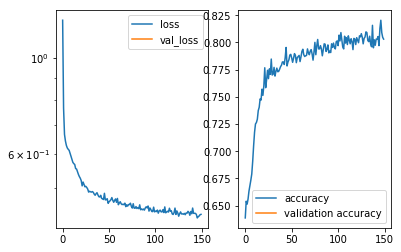

In [42]:
model = KerasClassifier(build_fn=create_model, callbacks=fit_callbacks, **best_params)
model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, shuffle=True)

In [47]:
model = create_model(**best_params)
model.load_weights(filepath)

### Define Analysis Functions

In [48]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Evaluate on Test Data

In [49]:
y_prob = model.predict(X_test)
y_pred = np.round(y_prob)

# y_prob = model.predict_proba(X_test)[:,1]
# y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cohen = cohen_kappa_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)
print("Cohen's Kappa:", cohen)

Accuracy: 0.8058124174372523
Precision: 0.8441295546558705
Recall: 0.8562628336755647
F1: 0.8501529051987767
Cohen's Kappa: 0.5743954165248355


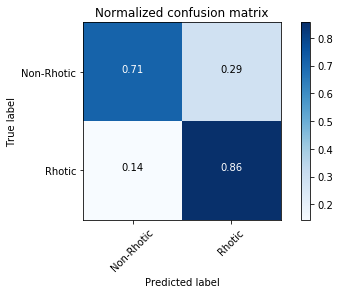

In [50]:
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])
plot_confusion_matrix(cnf_matrix, classes=['Non-Rhotic', 'Rhotic'], normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('results/confusion_matrix.png', bbox_inches='tight')

ROC AUC Score: 0.8693664917484221


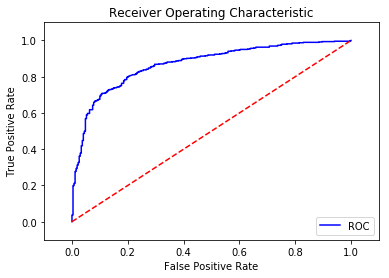

<Figure size 432x288 with 0 Axes>

In [51]:
# y_prob = model.predict_proba(X_test)#[:,1]
false_pos, true_pos, threshold = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", roc_auc)

plt.title('Receiver Operating Characteristic')
plt.plot(false_pos, true_pos, 'b', label='ROC')
plt.plot([0, 1], [0, 1],'r--')
plt.legend(loc = 'lower right')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.savefig('results/roc.png', bbox_inches='tight')